In [1]:
import pickle

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn

# PATH HACKING
import pathlib
import sys
_path = str(pathlib.Path('..').resolve().absolute())
if _path not in sys.path:
    sys.path.insert(0, _path)
from gd1_helpers.membership import BackgroundModel, StreamModel, JointModel

model has 180 parameters


# Base model class and helper functions

See: `3-Initial-stream-track.ipynb`

In [2]:
g = GaiaData('../data/gd1-GaiaDR3-PS1DR2-joined.fits')

phi2_cut = (-7, 5)
phi2_mask = (g.gd1_phi2 > phi2_cut[0]) & (g.gd1_phi2 < phi2_cut[1])
g = g[phi2_mask]

len(g)

6520791

In [3]:
masks = at.Table.read('../cache/init-masks.fits')[phi2_mask]
masks['G19.5'] = g.phot_g_mean_mag < 19.5*u.mag

In [4]:
with open('../data/galcen_frame.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [5]:
c = g.get_skycoord(
    distance=coord.Distance(distmod=g.rough_distmod),
    radial_velocity=0*u.km/u.s
)
gd1_frame = gc.GD1Koposov10()
c_gd1 = c.transform_to(gd1_frame)
c_gd1_refl = gc.reflex_correct(c_gd1, galcen_frame)

Note: We use a past distance trend (de Boer paper) to compute initial solar reflex-corrected proper motions, but do a conservative cut using these.

In [6]:
pm_cov = g.get_cov()[:, 3:5, 3:5]
pm_cov_gd1 = gc.transform_pm_cov(c, pm_cov, gd1_frame)

pm1 = c_gd1_refl.pm_phi1_cosphi2.value
pm2 = c_gd1_refl.pm_phi2.value
pm1_err = np.sqrt(pm_cov_gd1[:, 0, 0])
pm2_err = np.sqrt(pm_cov_gd1[:, 1, 1])

pm1_cut = (-100, -1.)
masks['pm1_cut'] = (pm1 < pm1_cut[1]) & (pm1 > pm1_cut[0])

In [7]:
BackgroundModel.pm1_cut = pm1_cut
BackgroundModel.phi2_cut = phi2_cut

StreamModel.pm1_cut = pm1_cut
StreamModel.phi2_cut = phi2_cut

# Stream and background trends

For membership modeling, we are going to do initial cuts on:
- apparent G magnitude, $G < 19.5$
- in CMD mask using distance trend from de Boer
- proper motion filter to remove bulk of disk/halo

In [8]:
def get_pcls(x, y, phi1_bins, qs=None):
    if qs is None:
        qs = [5, 16, 50, 84, 95]
    
    pcls = {}
    for q in [5, 16, 50, 84, 95]:
        stat = scs.binned_statistic(
            x, 
            y, 
            bins=phi1_bins,
            statistic=lambda x: np.percentile(x, q)
        )
        pcls[q] = stat.statistic
    return pcls

Text(0, 0.5, '$\\mu_{\\phi_2}$')

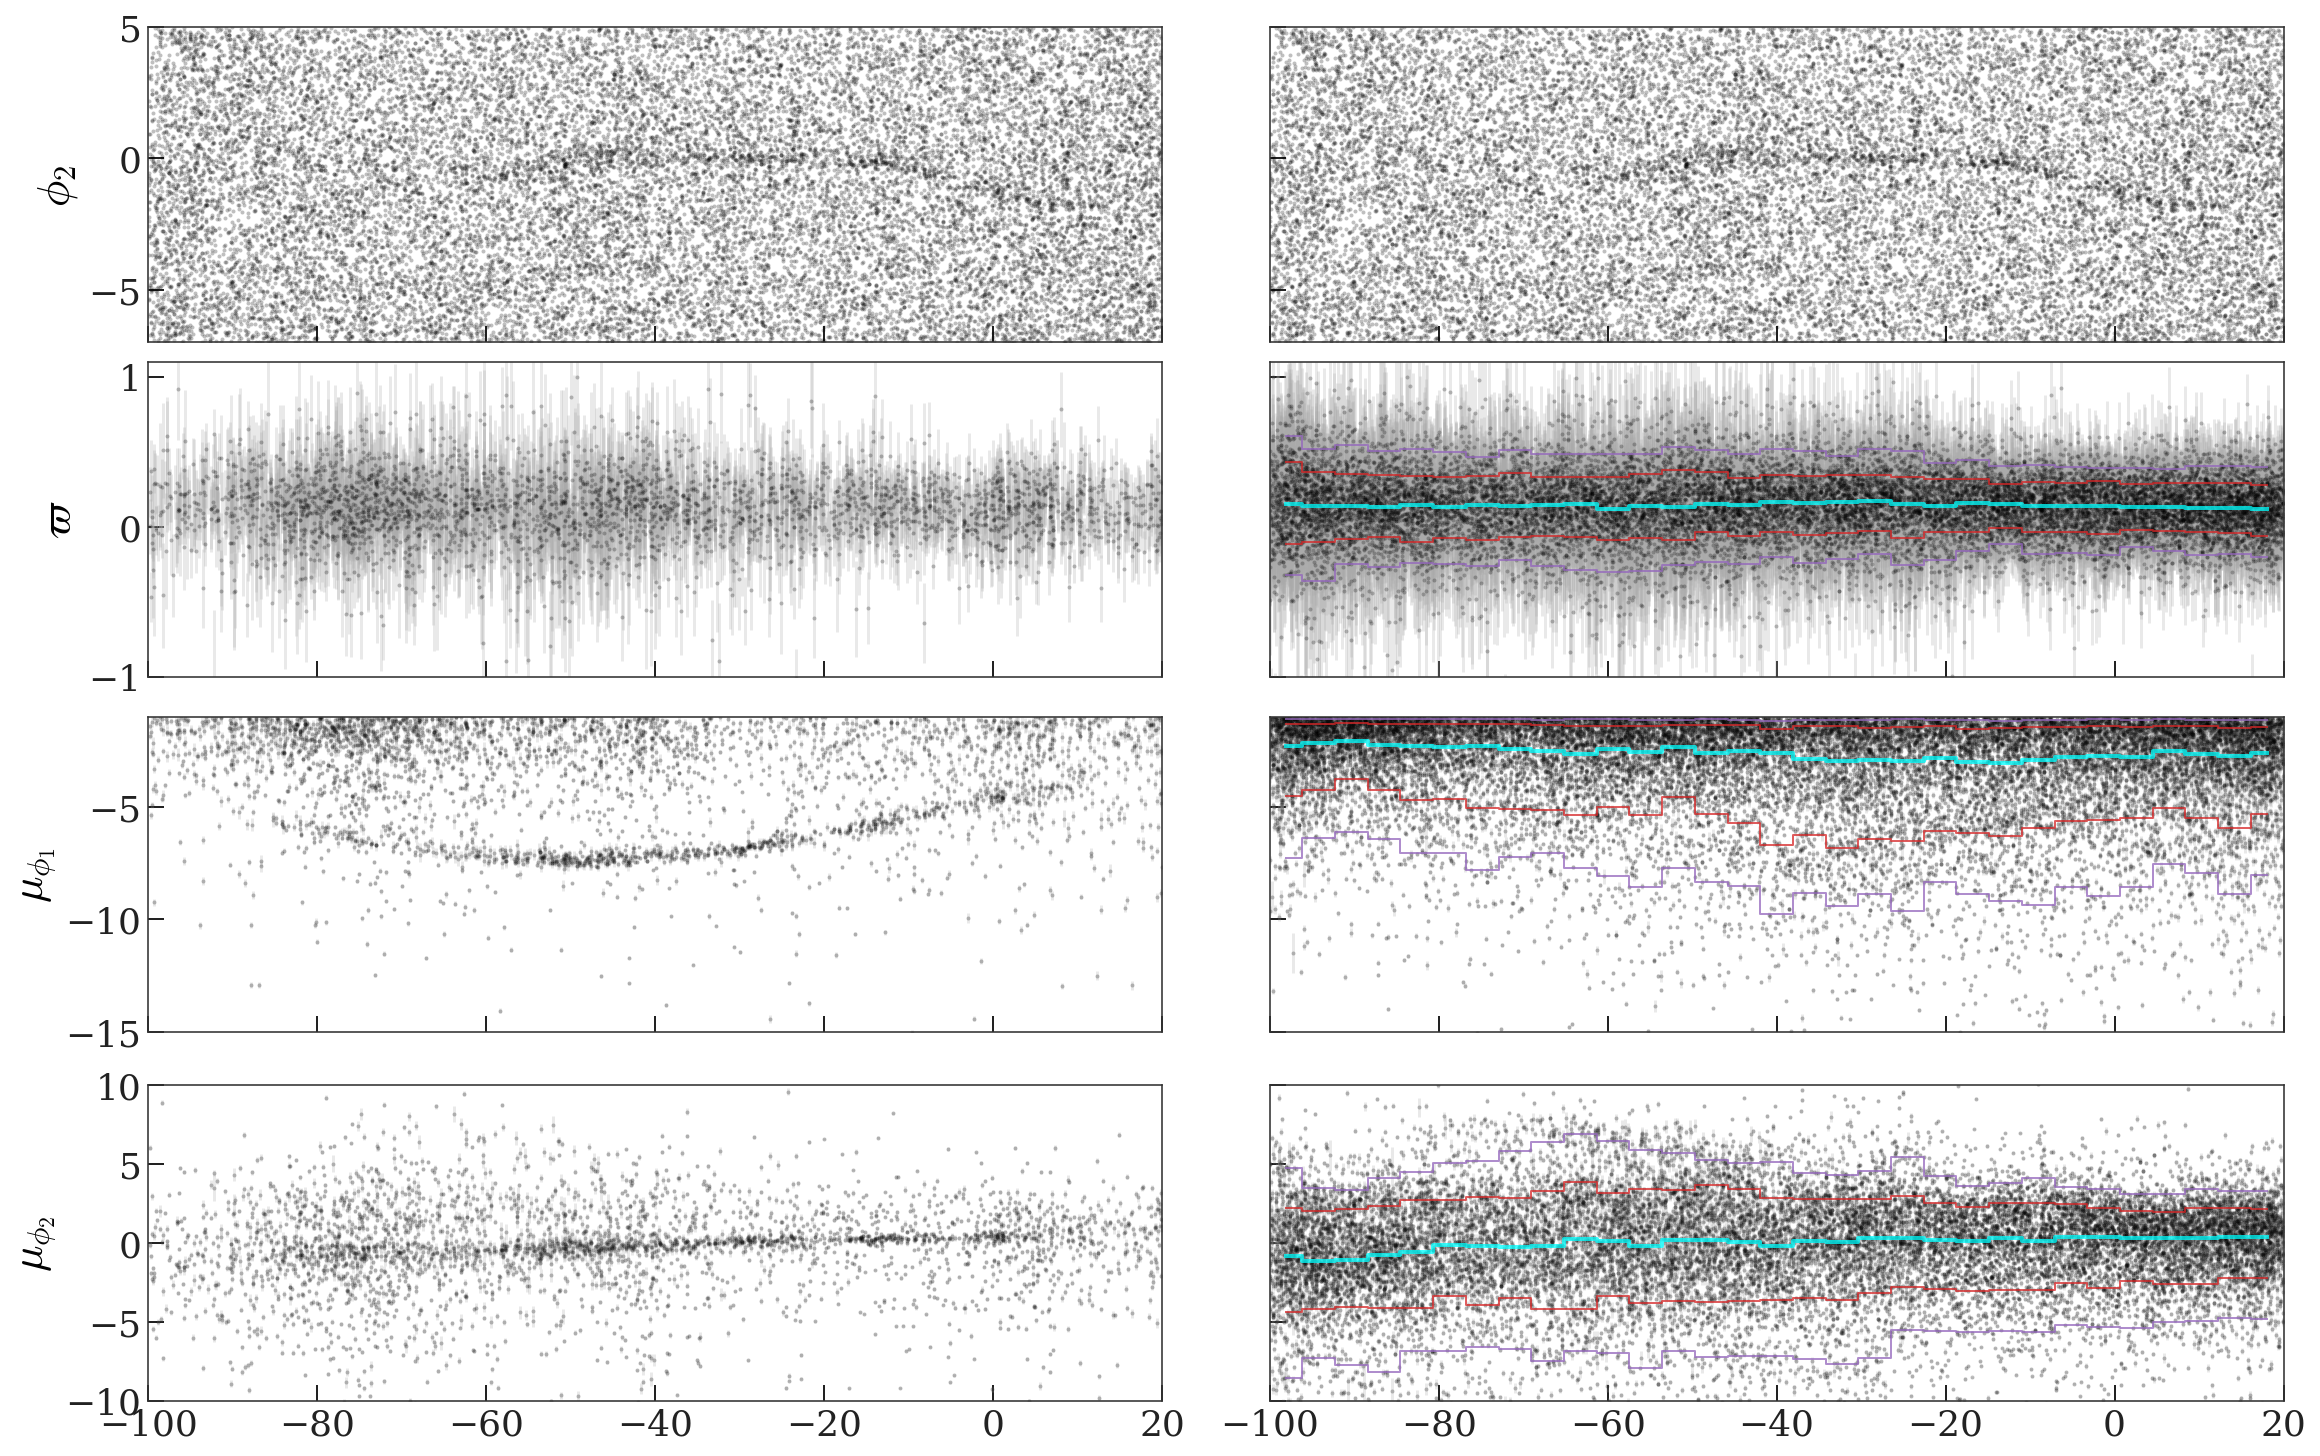

In [9]:
_base_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm1_cut']
phi1_bins = np.linspace(-100, 20, 32)
phi1_binc = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])
style = dict(
    ls='none',
    marker='o',
    mew=0, 
    ms=2.,
    ecolor='#aaaaaa',
    alpha=0.25
)

fig, axes = plt.subplots(4, 2, figsize=(16, 10), 
                         sharex=True, sharey='row', constrained_layout=True)


mask1 = _base_mask
mask2 = _base_mask
axes[0, 0].errorbar(g.gd1_phi1[mask1], g.gd1_phi2[mask1], **style)
axes[0, 1].errorbar(g.gd1_phi1[mask2], g.gd1_phi2[mask2], **style)
axes[0, 0].set_ylim(-7, 5.)

mask1 = _base_mask & masks['sky_track']
mask2 = _base_mask & ~masks['sky_track']

ys = [g.parallax.value, c_gd1_refl.pm_phi1_cosphi2.value, c_gd1_refl.pm_phi2.value]
yerrs = [g.parallax_error.value, np.sqrt(pm_cov_gd1[:, 0, 0]), np.sqrt(pm_cov_gd1[:, 1, 1])]
for i, y, yerr in zip(range(1, 3+1), ys, yerrs):
    for ax, mask in zip(axes[i], [mask1, mask2]):
        ax.errorbar(g.gd1_phi1[mask], y[mask], yerr[mask], **style)
        
    # only do for background plots:
    pcls = get_pcls(g.gd1_phi1[mask], y[mask], phi1_bins)
    ax.plot(phi1_binc, pcls[50], marker='', drawstyle='steps-mid', 
            color='cyan', lw=2, alpha=0.75, zorder=100)
    
    for j in [16, 84]:
        ax.plot(phi1_binc, pcls[j], marker='', drawstyle='steps-mid', 
                color='tab:red', lw=1, alpha=0.75, zorder=100)
    
    for j in [5, 95]:
        ax.plot(phi1_binc, pcls[j], marker='', drawstyle='steps-mid', 
                color='tab:purple', lw=1, alpha=0.75, zorder=100)
                  
axes[1, 0].set_ylim(-1, 1.1)
axes[2, 0].set_ylim(-15, pm1_cut[1])
axes[3, 0].set_ylim(-10, 10)

axes[0, 0].set_xlim(-100, 20)
axes[0, 0].set_ylabel(r'$\phi_2$')
axes[1, 0].set_ylabel(r'$\varpi$')
axes[2, 0].set_ylabel(r'$\mu_{\phi_1}$')
axes[3, 0].set_ylabel(r'$\mu_{\phi_2}$')

# Background model


## Initialization

As an example and for initialization, we determine initial parameters from the area outside the sky track:

In [10]:
bkg_init_p = {}

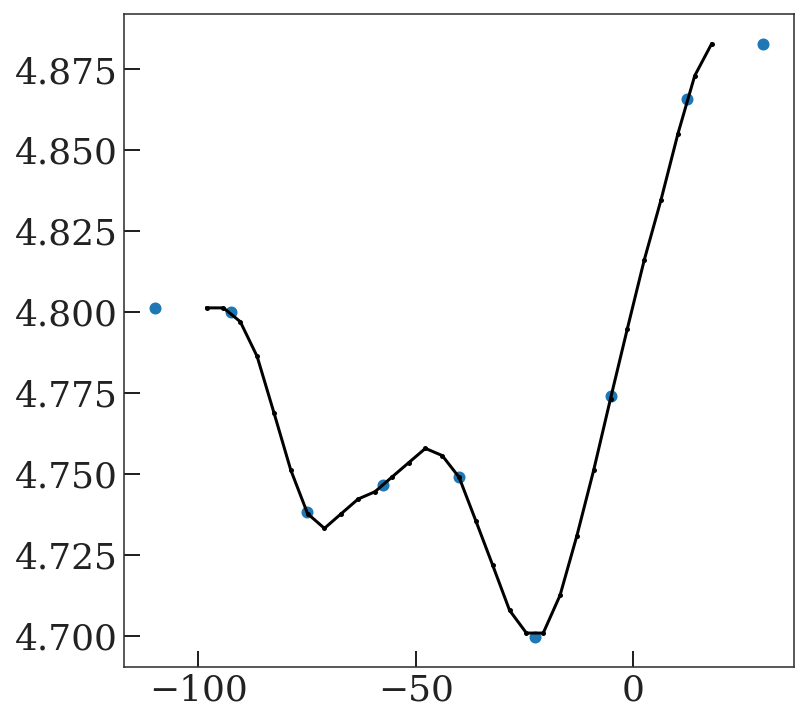

In [11]:
mask = _base_mask

tmp_lim = (-3, 1)
H, _ = np.histogram(
    g.gd1_phi1[mask & ((g.gd1_phi2 < tmp_lim[0]) | (g.gd1_phi2 > tmp_lim[1]))], 
    bins=phi1_bins
)

dx = phi1_bins[1] - phi1_bins[0]
H = np.log(scn.gaussian_filter(H, 2.) / dx)
plt.errorbar(phi1_binc, H)

tmp = sci.InterpolatedUnivariateSpline(phi1_binc, H, ext=3)
bkg_init_p['ln_n0'] = tmp(BackgroundModel.ln_n0_knots)
plt.scatter(
    BackgroundModel.ln_n0_knots, 
    bkg_init_p['ln_n0'], 
    color='tab:blue'
)

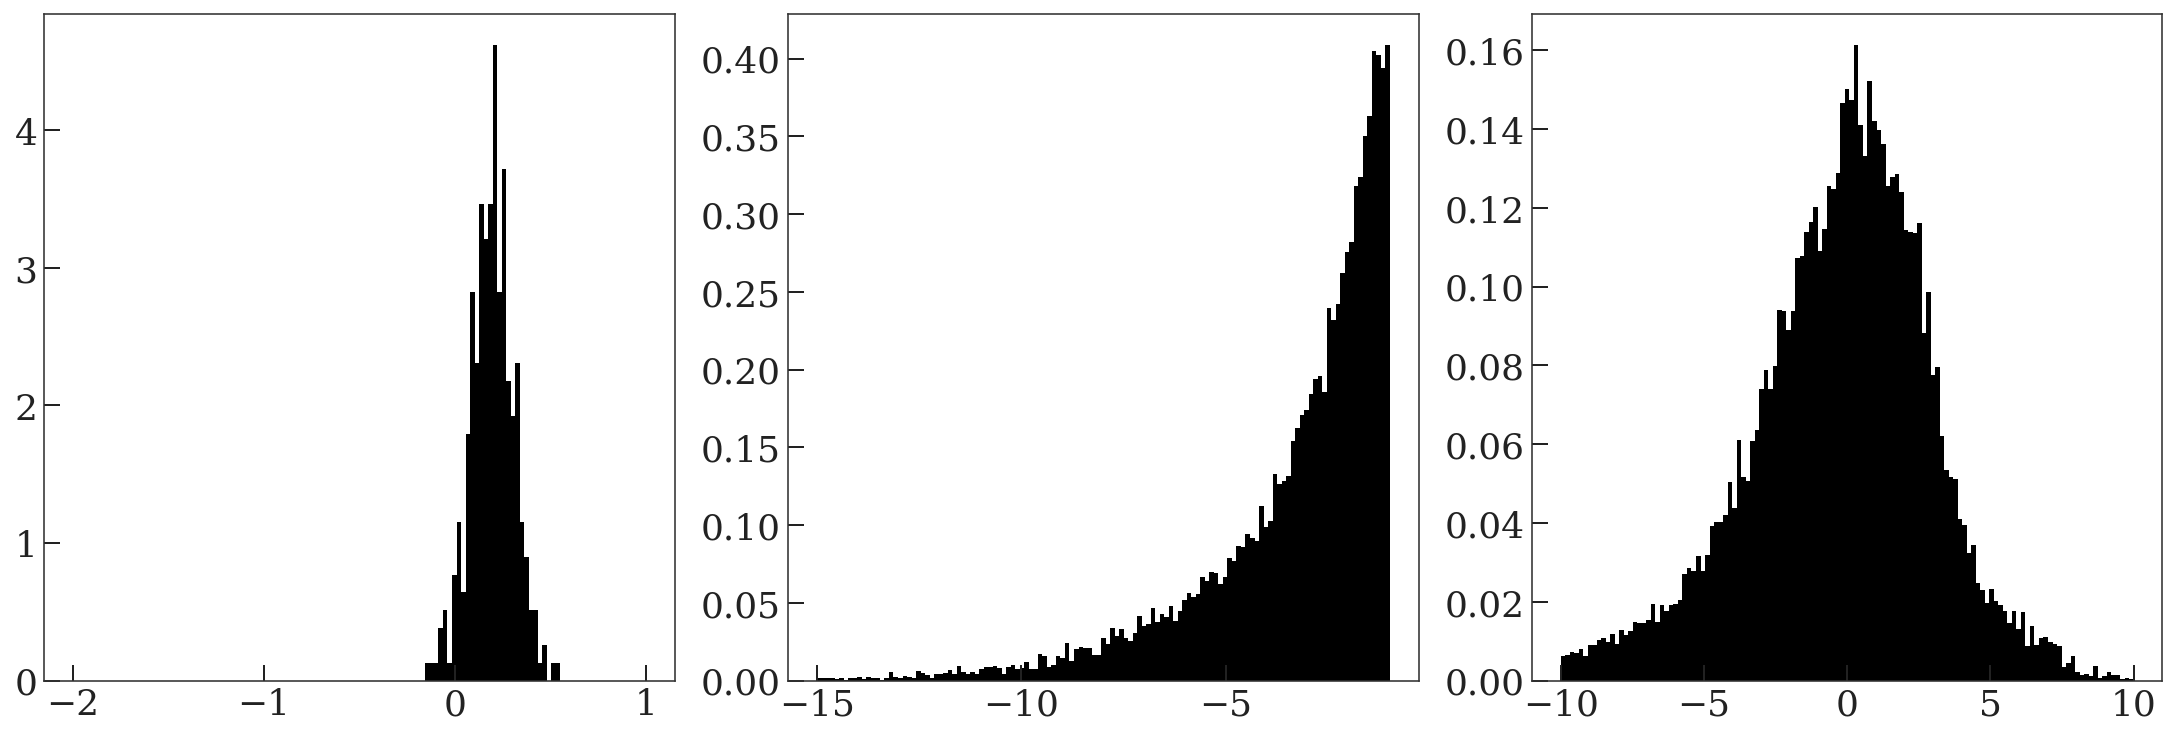

In [12]:
mask = _base_mask & ~masks['sky_track'] #& (g.gd1_phi1 > -20) & (g.gd1_phi1 < 20)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False,
                         constrained_layout=True)

axes[0].hist(g.parallax.value[mask & (g.parallax_error < 0.1*u.mas)], bins=np.linspace(-2, 1, 128), density=True)
axes[1].hist(pm1[mask], bins=np.linspace(-15, pm1_cut[1], 128), density=True)
axes[2].hist(pm2[mask], bins=np.linspace(-10, 10, 128), density=True);

In [13]:
from gd1_helpers.membership.helpers import two_truncnorm_mixture_ln_prob, ln_normal

x0_pm1 = jnp.array([0.65, 0.75, -4, np.log(3), np.log(4)])

@jax.jit
def objective(p, data, data_err):
    ln_prob = two_truncnorm_mixture_ln_prob(p, data, data_err, *pm1_cut)
    ln_prob = ln_prob + ln_normal(p[1], 0, 5) + ln_normal(p[2], 0, 5)
    return - ln_prob.sum() / len(data)

obj_grad = jax.jit(jax.grad(objective))
res_pm1 = sco.minimize(
    objective, 
    x0=x0_pm1,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=[(0, 1), (-10, 20), (-10, 20), (-5, 5), (-5, 5)],
    args=(pm1[mask], pm1_err[mask] * 0.),
    options=dict(maxls=1000)
)
print(res_pm1)
assert res_pm1.success

      fun: DeviceArray(5.32008993, dtype=float64)
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.90314160e-06,  2.21718385e-06, -1.46215347e-06, -5.60762745e-06,
       -4.33806490e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.54029594, 0.00680771, 0.00313603, 0.67611115, 1.5591491 ])


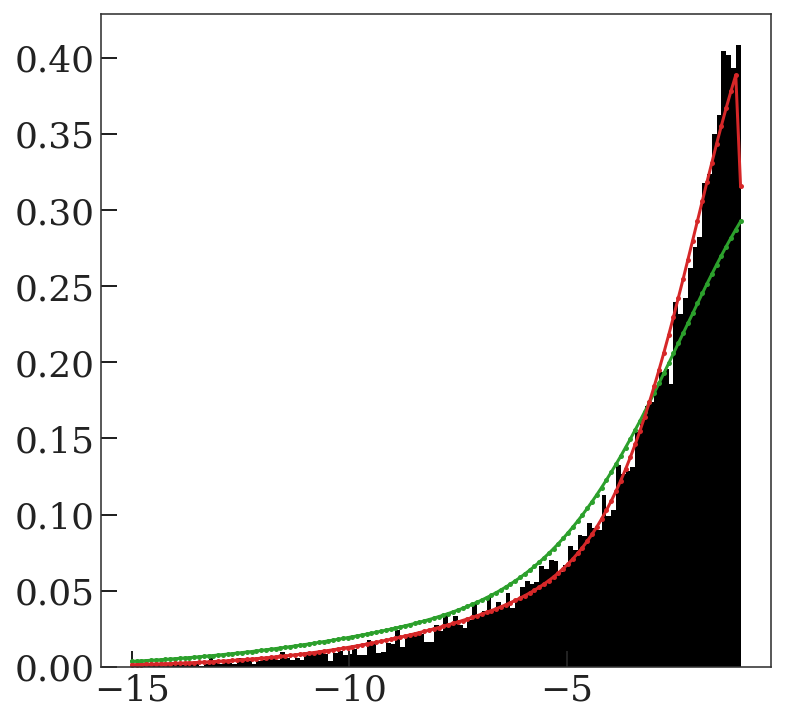

In [14]:
grid = np.linspace(-15, -1, 128)
plt.hist(pm1[mask], bins=np.linspace(-15, -1, 128), density=True)
plt.plot(grid, np.exp(two_truncnorm_mixture_ln_prob(x0_pm1, grid, 0., *pm1_cut)), color='tab:green')
plt.plot(grid, np.exp(two_truncnorm_mixture_ln_prob(res_pm1.x, grid, 0., *pm1_cut)), color='tab:red')

In [15]:
n = 0
for name, size in BackgroundModel.param_names.items():
    if name.endswith('_pm1'):
        bkg_init_p[name] = np.full(size, res_pm1.x[n])
        n += 1 

In [16]:
from gd1_helpers.membership.helpers import two_norm_mixture_ln_prob, ln_normal

x0_pm2 = [0.8, 0.75, -4, np.log(2.5), np.log(4)]

@jax.jit
def objective(p, data, data_err):
    return -two_norm_mixture_ln_prob(p, data, data_err).sum() / len(data)

obj_grad = jax.jit(jax.grad(objective))
res_pm2 = sco.minimize(
    objective, 
    x0=x0_pm2,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=[(0, 1), (-10, 10), (-10, 10), (-5, 5), (-5, 5)],
    args=(pm2[mask], pm2_err[mask]),
    options=dict(maxls=1000)
)
res_pm2

      fun: DeviceArray(2.60532975, dtype=float64)
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.76742656e-07,  9.69051169e-09, -9.86831814e-08,  4.02073060e-07,
       -1.34599355e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 28
      nit: 24
     njev: 28
   status: 0
  success: True
        x: array([ 0.71068883,  0.35522364, -2.123647  ,  0.85947703,  1.41360834])

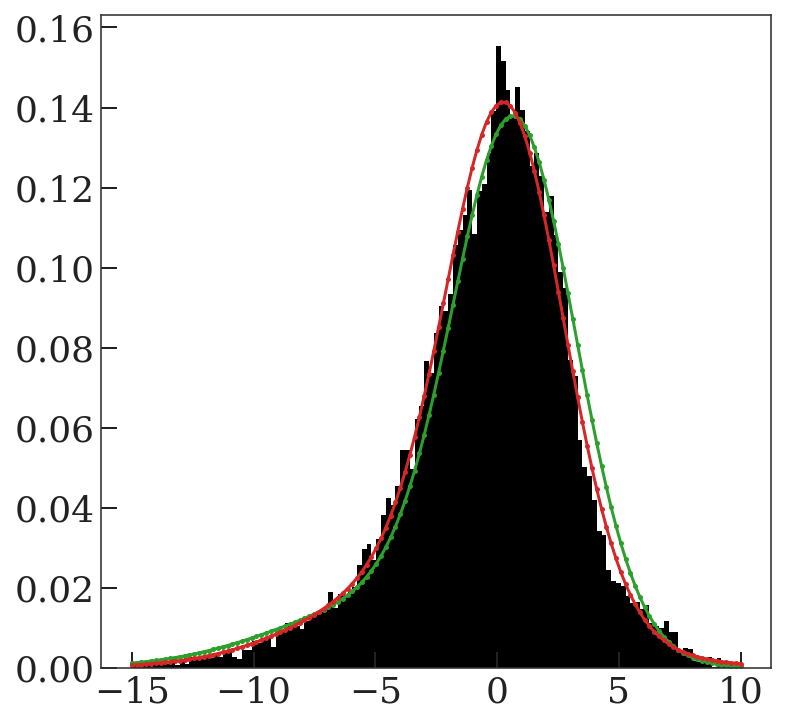

In [17]:
grid = np.linspace(-15, 10, 128)
plt.hist(pm2[mask], bins=np.linspace(-15, 10, 128), density=True)
plt.plot(grid, np.exp(two_norm_mixture_ln_prob(x0_pm2, grid, 0.)), color='tab:green')
plt.plot(grid, np.exp(two_norm_mixture_ln_prob(res_pm2.x, grid, 0.)), color='tab:red')

In [18]:
n = 0
for name, size in BackgroundModel.param_names.items():
    if name.endswith('_pm2'):
        bkg_init_p[name] = np.full(size, res_pm2.x[n])
        n += 1 

In [19]:
bkg_init_p

{'ln_n0': array([4.80135356, 4.80014702, 4.73821655, 4.74653342, 4.74905406,
        4.69973094, 4.77427984, 4.86585683, 4.88286505]),
 'w_pm1': array([0.54029594, 0.54029594, 0.54029594, 0.54029594, 0.54029594,
        0.54029594, 0.54029594]),
 'mean1_pm1': array([0.00680771, 0.00680771, 0.00680771, 0.00680771, 0.00680771,
        0.00680771, 0.00680771]),
 'ln_std1_pm1': array([0.00313603, 0.00313603, 0.00313603, 0.00313603, 0.00313603,
        0.00313603, 0.00313603]),
 'mean2_pm1': array([0.67611115, 0.67611115, 0.67611115, 0.67611115, 0.67611115,
        0.67611115, 0.67611115]),
 'ln_std2_pm1': array([1.5591491, 1.5591491, 1.5591491, 1.5591491, 1.5591491, 1.5591491,
        1.5591491]),
 'w_pm2': array([0.71068883, 0.71068883, 0.71068883, 0.71068883, 0.71068883,
        0.71068883, 0.71068883]),
 'mean1_pm2': array([0.35522364, 0.35522364, 0.35522364, 0.35522364, 0.35522364,
        0.35522364, 0.35522364]),
 'ln_std1_pm2': array([-2.123647, -2.123647, -2.123647, -2.123647, -2.1

## Test optimization:

In [20]:
test_bkg_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm1_cut']

data = {
    'phi1': c_gd1.phi1.degree[test_bkg_mask],
    'phi2': c_gd1.phi2.degree[test_bkg_mask],
    'pm1': pm1[test_bkg_mask],
    'pm1_error': pm1_err[test_bkg_mask],
    'pm2': pm2[test_bkg_mask],
    'pm2_error': pm2_err[test_bkg_mask],
}

BackgroundModel.ln_likelihood(bkg_init_p, data)

DeviceArray(-62753.53739881, dtype=float64)

In [21]:
bkg_init_pvec = BackgroundModel.pack_pars(bkg_init_p)
func = jax.value_and_grad(BackgroundModel.objective)
func(bkg_init_pvec, test_bkg_mask.sum(), data)

(DeviceArray(2.8534923, dtype=float64),
 DeviceArray([-6.36801387e-04, -4.55711051e-02, -4.80034998e-02,
              -5.15682959e-02, -5.66218819e-02, -4.98329038e-02,
              -5.28246682e-02, -5.25791503e-02, -1.13165131e-03,
              -3.40343848e-03, -4.59451808e-02,  4.05353776e-03,
               3.51383611e-02,  5.05253238e-02,  6.95576514e-03,
              -1.92071381e-04, -2.70825324e-04, -4.09752799e-03,
              -6.17609529e-04, -1.35247330e-06,  2.56302382e-03,
               1.63904264e-03,  4.35501919e-05, -1.55856082e-04,
              -2.36729827e-03, -2.27527270e-04,  1.73152455e-03,
               2.01951428e-03, -1.25206724e-04, -1.78967061e-05,
               1.65569611e-03,  2.42363876e-02,  1.90746350e-03,
              -4.52141062e-03, -2.16230720e-02, -1.00075179e-02,
              -1.12087586e-04,  1.36392853e-03,  2.22097580e-02,
               4.32786489e-03, -1.57304811e-02, -2.01305180e-02,
               7.76085597e-04,  1.60479193e-04,  2

In [22]:
bkg_res = sco.minimize(
    jax.value_and_grad(BackgroundModel.objective),
    bkg_init_pvec,
    args=(test_bkg_mask.sum(), data),
    jac=True,
    method="bfgs",
    options=dict(maxiter=100_000, maxls=1000),
)
print(bkg_res)

bkg_res_p =  BackgroundModel.unpack_pars(bkg_res.x)
bkg_res_p

/tmp/ipykernel_723625/2474015751.py:1: OptimizeWarning: Unknown solver options: maxls
  bkg_res = sco.minimize(


      fun: 2.7244243567709314
 hess_inv: array([[ 1.02898400e+03, -3.57236692e+01,  3.35247242e+01, ...,
        -7.47092186e+00,  5.16864850e+00, -1.06271273e+02],
       [-3.57236692e+01,  7.63683225e+00, -1.37124855e+00, ...,
         1.71452557e-01, -1.72753831e-01,  3.71297222e+00],
       [ 3.35247242e+01, -1.37124855e+00,  7.20686873e+00, ...,
        -1.72084979e-01, -1.12772013e-02, -3.25420046e+00],
       ...,
       [-7.47092186e+00,  1.71452557e-01, -1.72084979e-01, ...,
         2.54985347e+01, -4.60340905e+00,  6.71155217e+01],
       [ 5.16864850e+00, -1.72753831e-01, -1.12772013e-02, ...,
        -4.60340905e+00,  2.19342893e+01, -6.51014471e+01],
       [-1.06271273e+02,  3.71297222e+00, -3.25420046e+00, ...,
         6.71155217e+01, -6.51014471e+01,  1.19629709e+03]])
      jac: array([ 9.53836667e-08,  1.10768125e-07, -3.09819550e-07,  5.25266564e-08,
       -8.59232883e-08, -1.76923946e-07, -9.96677693e-08,  3.47771603e-09,
       -5.45601446e-07, -8.83813947e-07, 

{'ln_n0': DeviceArray([4.83456904, 5.23481683, 5.14792878, 5.19597186, 5.23252358,
              5.14584909, 5.22060713, 5.31079367, 5.40905619],            dtype=float64),
 'ln_std1_pm1': DeviceArray([24.91127241, 24.82900605, 24.6384362 , 24.5395262 ,
              24.6361695 , 24.69964404, 24.63258734], dtype=float64),
 'ln_std1_pm2': DeviceArray([-2.98612594, -2.84735932, -2.82458671, -2.33923649,
              -1.71578012, -1.94977747, -1.89906313], dtype=float64),
 'ln_std2_pm1': DeviceArray([2.28818814, 2.11481416, 2.18046891, 2.28037919, 2.27193845,
              2.18285018, 2.50375224], dtype=float64),
 'ln_std2_pm2': DeviceArray([1.85363937, 1.33093434, 1.52181292, 1.43252943, 1.36250058,
              1.17660263, 1.37552032], dtype=float64),
 'mean1_pm1': DeviceArray([ 2.21951434,  1.81493421,  0.17020589, -1.35765743,
              -0.15805566, -0.03791115,  0.04227944], dtype=float64),
 'mean1_pm2': DeviceArray([-0.47968804, -0.25826708,  0.39477124,  0.54611063,
         

Text(0, 0.5, '$\\mu_{\\phi_2}$')

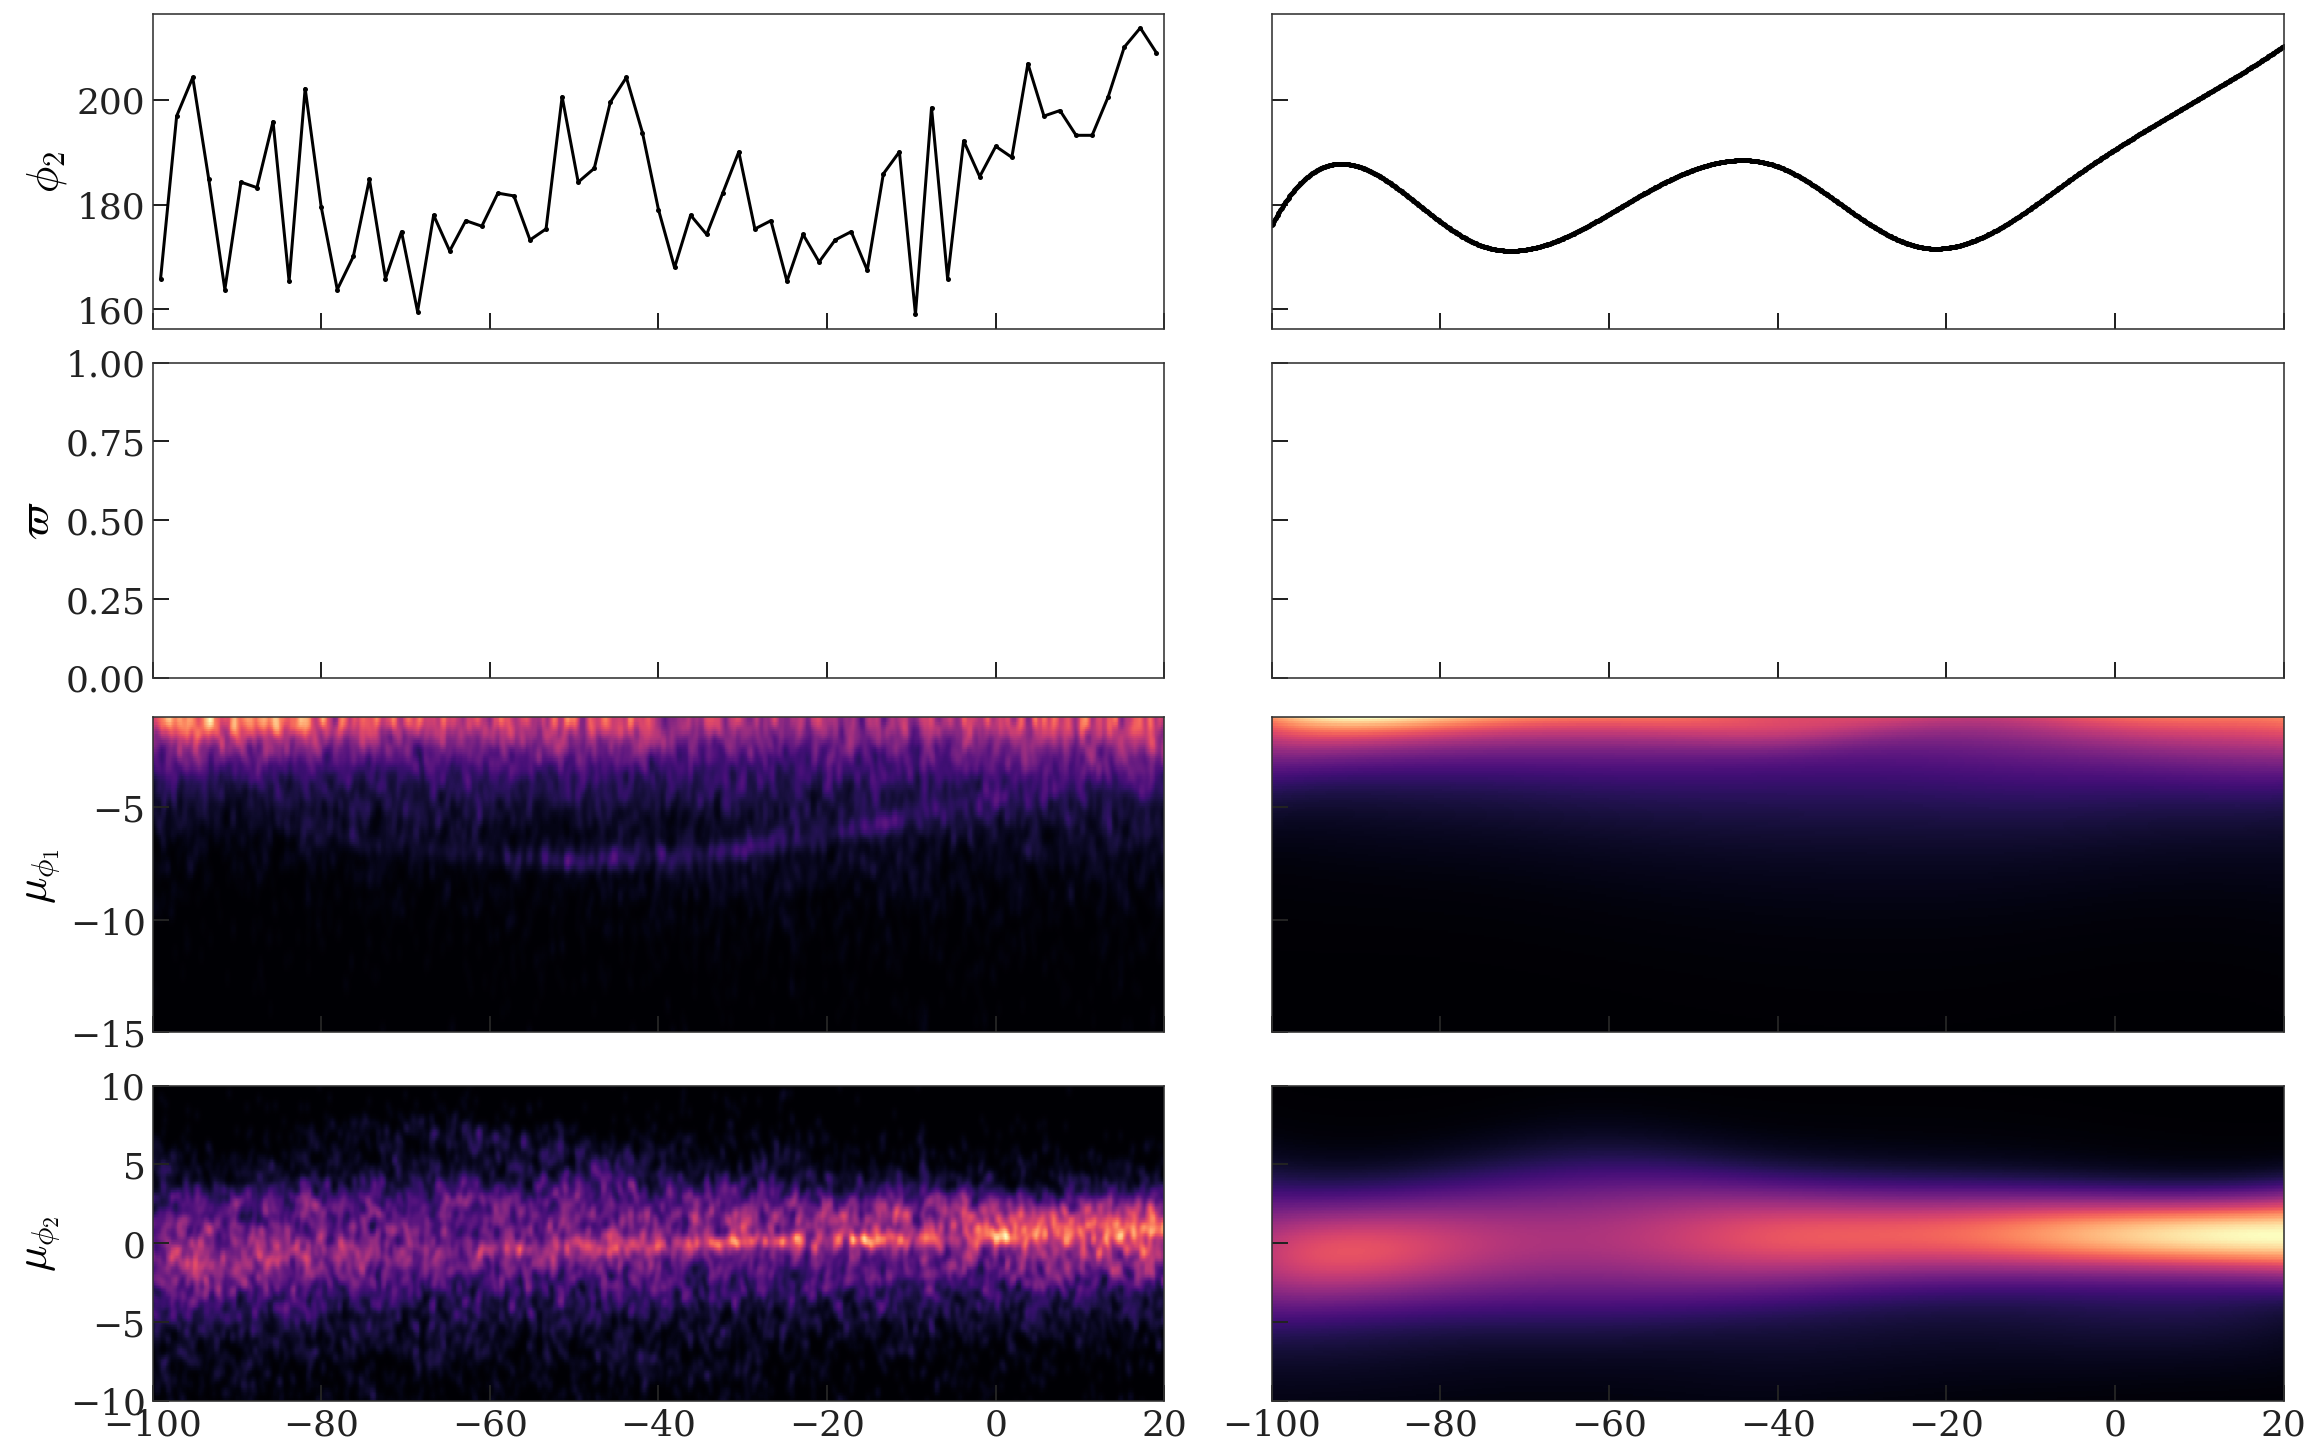

In [23]:
fig, axes = plt.subplots(
    4, 2, figsize=(16, 10), 
    sharex=True, sharey='row', constrained_layout=True
)

# phi1 density:
H, xe = np.histogram(
    c_gd1.phi1.degree[test_bkg_mask],
    bins=np.linspace(-100, 20, 64)
)
dx = xe[1] - xe[0]
xc = 0.5*(xe[:-1]+xe[1:])
axes[0, 0].plot(xc, H / dx)

plot_grid_phi1 = np.arange(-100, 20+1e-3, 0.1)
ln_n0_spl = sci.InterpolatedUnivariateSpline(
    BackgroundModel.ln_n0_knots,
    bkg_res_p['ln_n0'],
    k=3
)
axes[0, 1].plot(
    plot_grid_phi1, 
    np.exp(ln_n0_spl(plot_grid_phi1)), 
)

# pm1
plot_grid_pm1 = np.arange(-15, pm1_cut[1]+1e-3, 0.1)
H_data, *_ = np.histogram2d(
    c_gd1.phi1.degree[test_bkg_mask],
    pm1[test_bkg_mask],
    bins=(plot_grid_phi1, plot_grid_pm1)
)
H_data = scn.gaussian_filter(H_data, 3)
grid1, grid2 = np.meshgrid(plot_grid_phi1, plot_grid_pm1)
ln_n0 = BackgroundModel.ln_n0(grid1, bkg_res_p)
H = BackgroundModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.zeros_like(grid1)}, bkg_res_p)
ln_dens = ln_n0 + H
axes[2, 0].pcolormesh(grid1, grid2, H_data.T)
axes[2, 1].pcolormesh(grid1, grid2, np.exp(ln_dens), shading='auto')

# pm2
plot_grid_pm2 = np.arange(-15, 15+1e-3, 0.1)
H_data, *_ = np.histogram2d(
    c_gd1.phi1.degree[test_bkg_mask],
    pm2[test_bkg_mask],
    bins=(plot_grid_phi1, plot_grid_pm2)
)
H_data = scn.gaussian_filter(H_data, 3)
grid1, grid2 = np.meshgrid(plot_grid_phi1, plot_grid_pm2)
ln_n0 = BackgroundModel.ln_n0(grid1, bkg_res_p)
H = BackgroundModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.zeros_like(grid1)}, bkg_res_p)
ln_dens = ln_n0 + H
axes[3, 0].pcolormesh(grid1, grid2, H_data.T)
axes[3, 1].pcolormesh(grid1, grid2, np.exp(ln_dens), shading='auto')

# ---

# axes[1, 0].set_ylim(-1, 1.1)
axes[2, 0].set_ylim(-15, pm1_cut[1])
axes[3, 0].set_ylim(-10, 10)

axes[0, 0].set_xlim(-100, 20)
axes[0, 0].set_ylabel(r'$\phi_2$')
axes[1, 0].set_ylabel(r'$\varpi$')
axes[2, 0].set_ylabel(r'$\mu_{\phi_1}$')
axes[3, 0].set_ylabel(r'$\mu_{\phi_2}$')

Text(0, 0.5, '$\\mu_{\\phi_2}$')

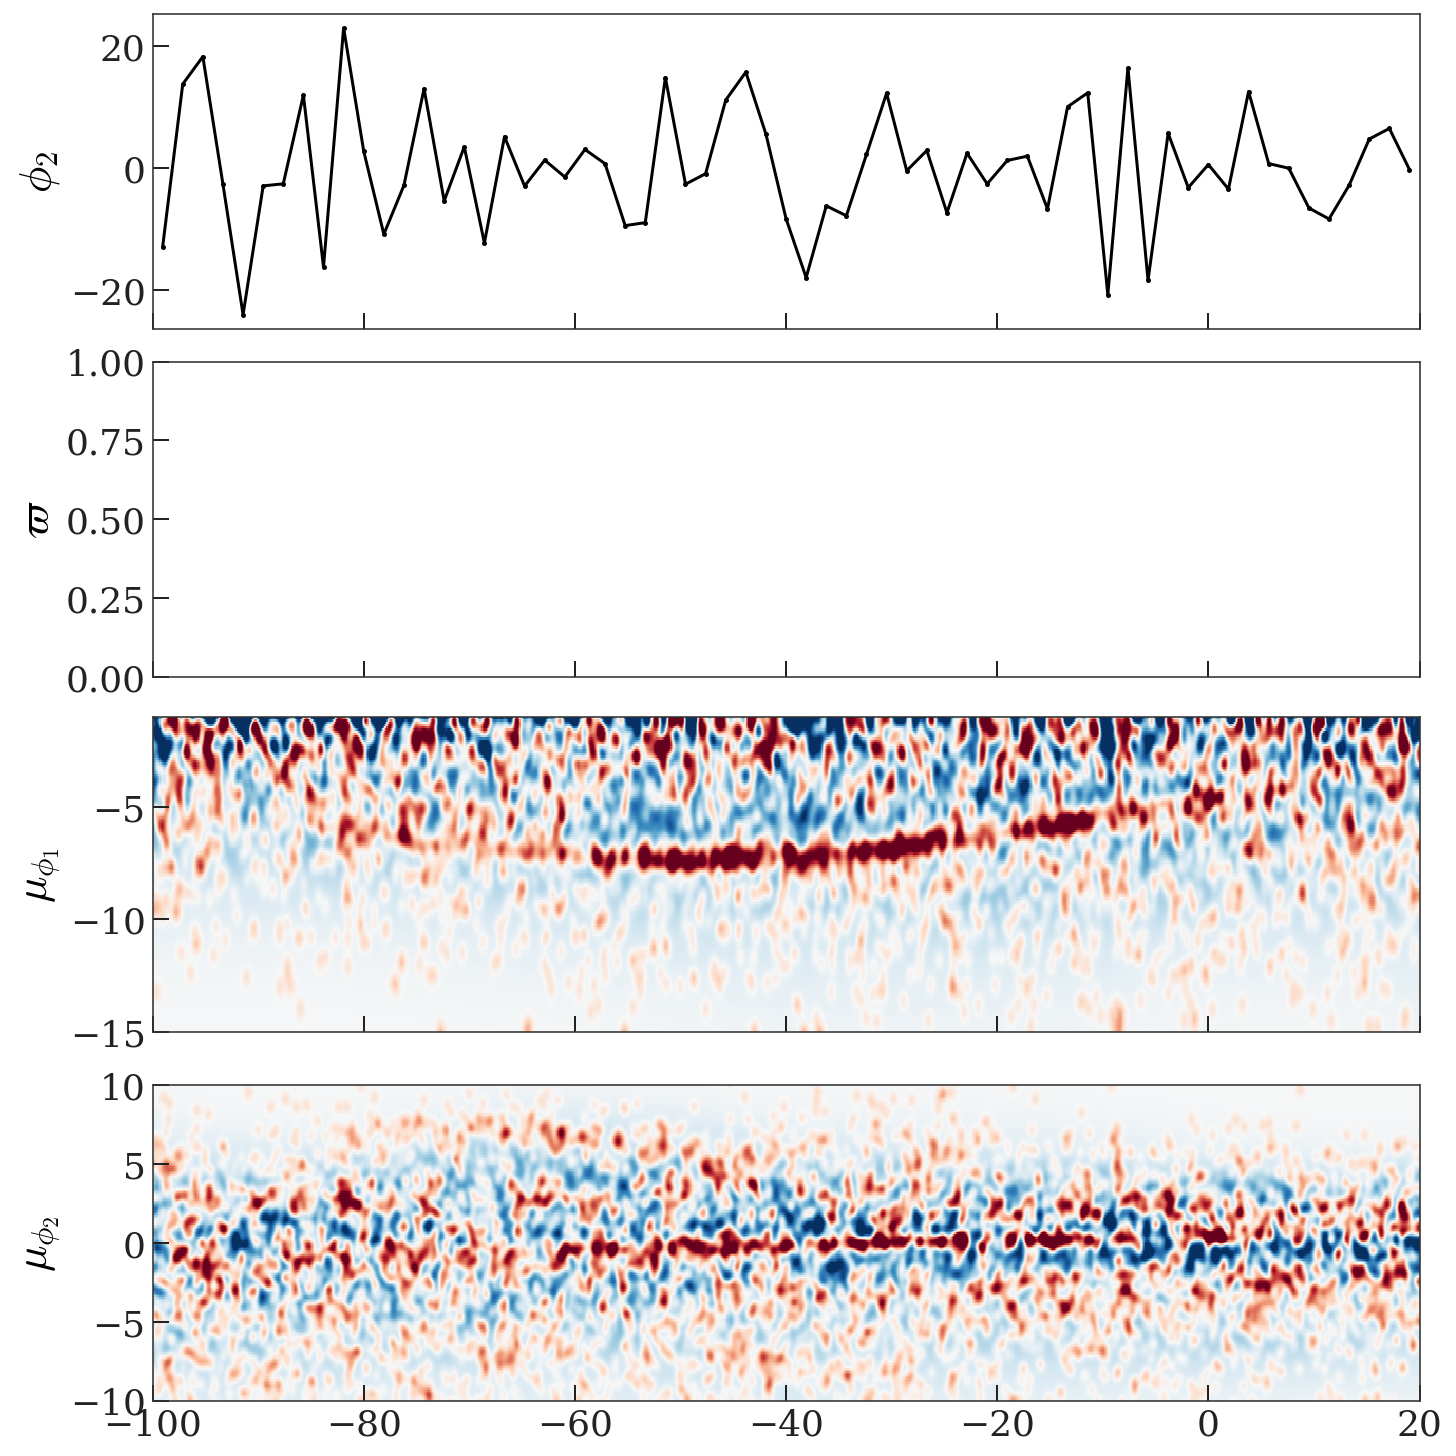

In [24]:
fig, axes = plt.subplots(
    4, 1, figsize=(10, 10), 
    sharex=True, sharey='row', constrained_layout=True
)

# phi1 density:
H, xe = np.histogram(
    c_gd1.phi1.degree[test_bkg_mask],
    bins=np.linspace(-100, 20, 64)
)
dx = xe[1] - xe[0]
xc = 0.5*(xe[:-1]+xe[1:])

plot_grid_phi1 = np.arange(-100, 20+1e-3, 0.1)
ln_n0_spl = sci.InterpolatedUnivariateSpline(
    BackgroundModel.ln_n0_knots,
    bkg_res_p['ln_n0'],
    k=3
)
axes[0].plot(xc, H / dx - np.exp(ln_n0_spl(xc)))

# pm1
plot_grid_pm1 = np.arange(-15, pm1_cut[1]+1e-3, 0.1)
H_data, *_ = np.histogram2d(
    c_gd1.phi1.degree[test_bkg_mask],
    pm1[test_bkg_mask],
    bins=(plot_grid_phi1, plot_grid_pm1)
)
H_data = scn.gaussian_filter(H_data / 0.01, 3)
grid1, grid2 = np.meshgrid(
    0.5 * (plot_grid_phi1[:-1] + plot_grid_phi1[1:]), 
    0.5 * (plot_grid_pm1[:-1] + plot_grid_pm1[1:]), 
)
ln_n0 = BackgroundModel.ln_n0(grid1, bkg_res_p)
H = BackgroundModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.zeros_like(grid1)}, bkg_res_p)
ln_dens = ln_n0 + H
axes[2].pcolormesh(grid1, grid2, H_data.T - np.exp(ln_dens), 
                   shading='auto', cmap='RdBu_r', vmin=-10, vmax=10)

# pm2
plot_grid_pm2 = np.arange(-15, 15+1e-3, 0.1)
H_data, *_ = np.histogram2d(
    c_gd1.phi1.degree[test_bkg_mask],
    pm2[test_bkg_mask],
    bins=(plot_grid_phi1, plot_grid_pm2)
)
H_data = scn.gaussian_filter(H_data / 0.01, 3)
grid1, grid2 = np.meshgrid(
    0.5 * (plot_grid_phi1[:-1] + plot_grid_phi1[1:]), 
    0.5 * (plot_grid_pm2[:-1] + plot_grid_pm2[1:]), 
)
ln_n0 = BackgroundModel.ln_n0(grid1, bkg_res_p)
H = BackgroundModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.zeros_like(grid1)}, bkg_res_p)
ln_dens = ln_n0 + H
axes[3].pcolormesh(grid1, grid2, H_data.T - np.exp(ln_dens), 
                   shading='auto', cmap='RdBu_r', vmin=-10, vmax=10)

# ---

# axes[1, 0].set_ylim(-1, 1.1)
axes[2].set_ylim(-15, pm1_cut[1])
axes[3].set_ylim(-10, 10)

axes[0].set_xlim(-100, 20)
axes[0].set_ylabel(r'$\phi_2$')
axes[1].set_ylabel(r'$\varpi$')
axes[2].set_ylabel(r'$\mu_{\phi_1}$')
axes[3].set_ylabel(r'$\mu_{\phi_2}$')

# Stream Model:

## Initialization:

In [25]:
stream_init_p = {}

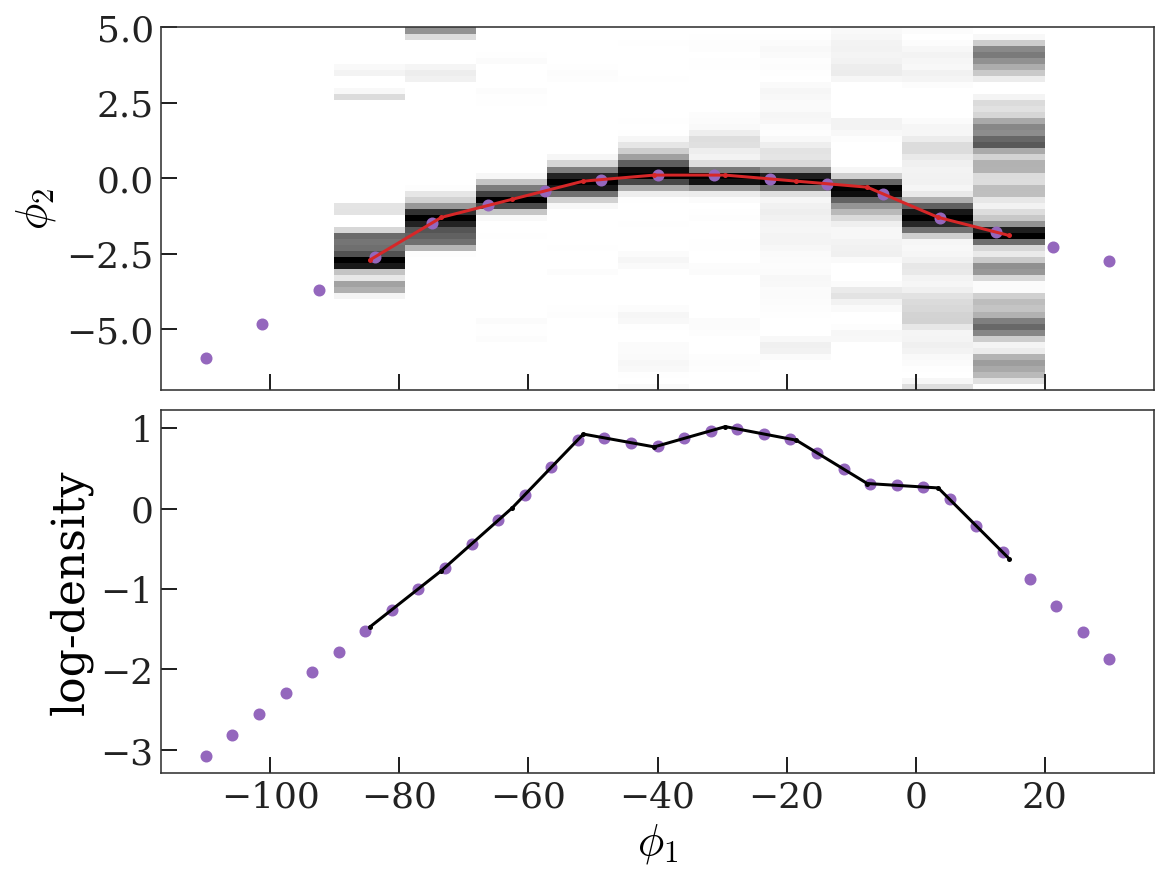

In [98]:
stream_init_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm_rough']

H, xe, ye = np.histogram2d(
    g.gd1_phi1[stream_init_mask],
    g.gd1_phi2[stream_init_mask],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-7, 5 + 1e-3, 0.2)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])

H /= (xe[1] - xe[0])
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel(r"$\phi_2$")
axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

stream_init_p['ln_n0'] = sci.InterpolatedUnivariateSpline(xc, H_ln_density, k=1)(StreamModel.ln_n0_knots)
stream_init_p['mean_phi2'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    StreamModel.phi2_knots
)
stream_init_p["ln_std_phi2"] = np.full_like(stream_init_p['mean_phi2'], -1)

axes[0].scatter(StreamModel.phi2_knots, stream_init_p['mean_phi2'], color='tab:purple')
axes[1].scatter(StreamModel.ln_n0_knots, stream_init_p['ln_n0'], color='tab:purple')

In [82]:
stream_plot_grid_phi1_1d = np.arange(-100, 20+1e-3, 0.1)
stream_plot_grid_phi2_1d = np.arange(phi2_cut[0], phi2_cut[1]+1e-3, 0.1)
stream_plot_grid_phi1, stream_plot_grid_phi2 = np.meshgrid(
    stream_plot_grid_phi1_1d, stream_plot_grid_phi2_1d
)

stream_ln_sky_prob_init = StreamModel.phi2(
    {'phi1': stream_plot_grid_phi1, 'phi2': stream_plot_grid_phi2}, 
    stream_init_p
)
stream_ln_sky_init = stream_ln_sky_prob_init + StreamModel.ln_n0(stream_plot_grid_phi1, stream_init_p)

Text(0, 0.5, '$\\phi_2$')

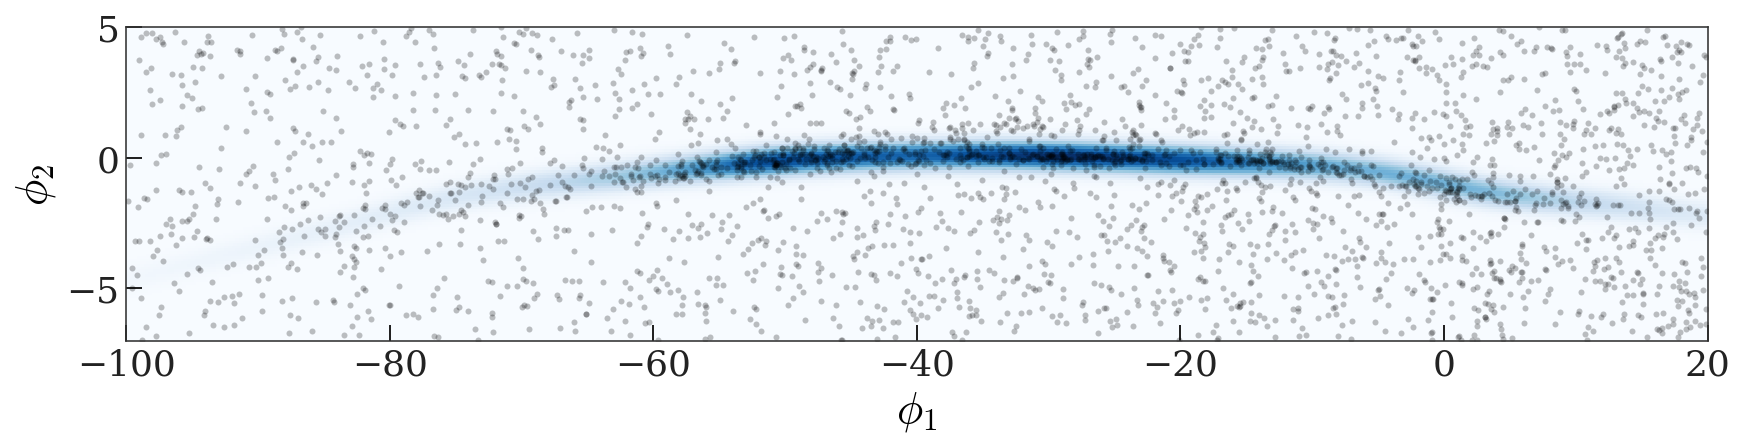

In [83]:
fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    g.gd1_phi1[stream_init_mask],
    g.gd1_phi2[stream_init_mask],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.pcolormesh(
    stream_plot_grid_phi1,
    stream_plot_grid_phi2,
    np.exp(stream_ln_sky_init),
    cmap="Blues",
    shading='auto'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

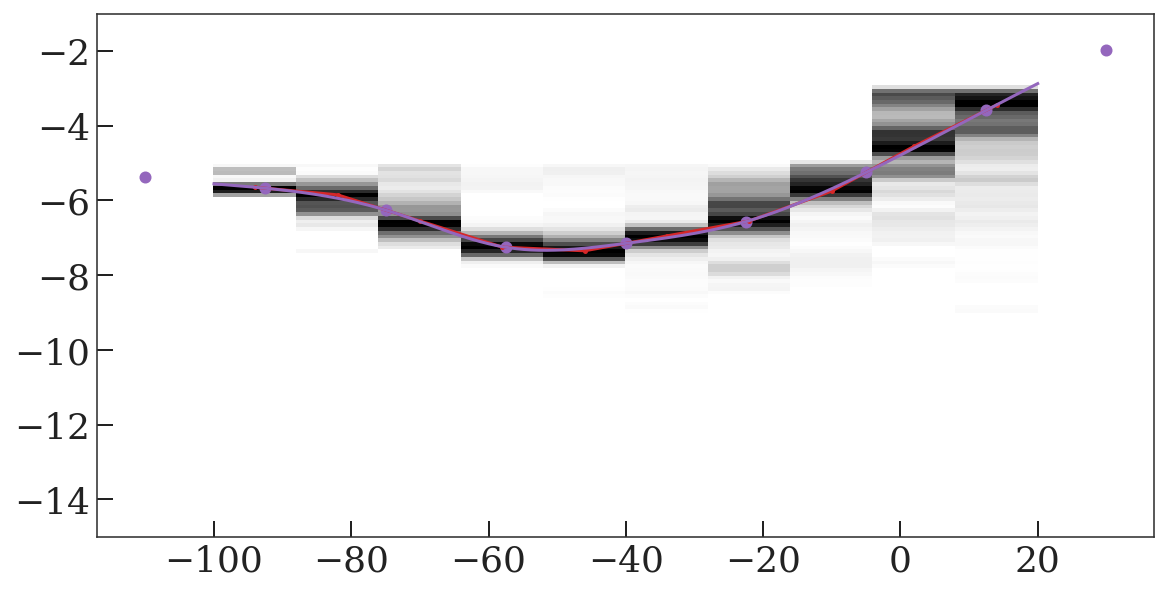

In [84]:
_mask = (
    (g.gd1_phi1 > 0) |
    ((g.gd1_phi1 <= 0) & (pm1 < -5))
)

H, xe, ye = np.histogram2d(
    g.gd1_phi1[stream_init_mask & _mask],
    pm1[stream_init_mask & _mask],
    bins=(np.linspace(-100, 20 + 1e-3, 11), np.arange(-15, pm1_cut[1]+1e-3, 0.1)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])
H /= (xe[1] - xe[0]) / 12
peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
cs = ax.pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
ax.plot(xc, yc[peak_idx], color="tab:red")

stream_init_p['mean_pm1'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    StreamModel.pm1_knots
)
stream_init_p['ln_std_pm1'] = np.full_like(StreamModel.pm1_knots, -3)

ax.scatter(StreamModel.pm1_knots, stream_init_p['mean_pm1'], color='tab:purple')
tmp_interp = sci.InterpolatedUnivariateSpline(
    StreamModel.pm1_knots,
    stream_init_p['mean_pm1'],
    k=3
)
ax.plot(plot_grid_phi1, tmp_interp(plot_grid_phi1), marker='', color='tab:purple')

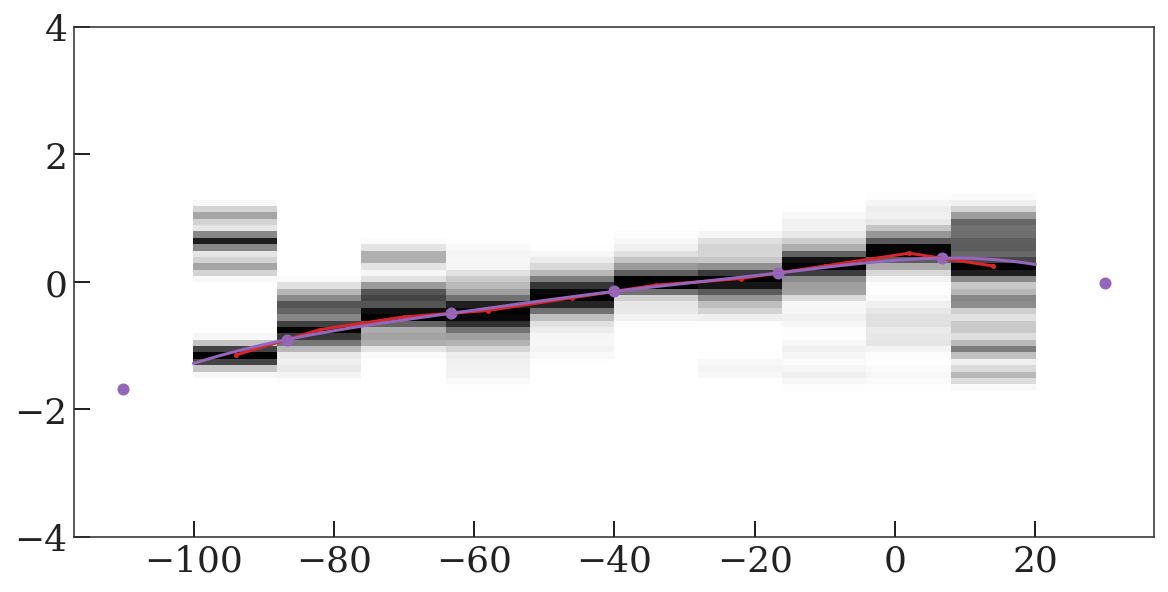

In [85]:
tmp_interp = sci.InterpolatedUnivariateSpline(
    StreamModel.pm1_knots,
    stream_init_p['mean_pm1'],
    k=3
)
_mask = np.abs(pm1 - tmp_interp(g.gd1_phi1)) < 0.1

H, xe, ye = np.histogram2d(
    g.gd1_phi1[stream_init_mask & _mask],
    pm2[stream_init_mask & _mask],
    bins=(np.linspace(-100, 20 + 1e-3, 11), np.arange(-4, 4+1e-3, 0.1)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])
H /= (xe[1] - xe[0]) / 12
peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
cs = ax.pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
ax.plot(xc, yc[peak_idx], color="tab:red")

stream_init_p['mean_pm2'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    StreamModel.pm2_knots
)
stream_init_p['ln_std_pm2'] = np.full_like(StreamModel.pm2_knots, -3)

ax.scatter(StreamModel.pm2_knots, stream_init_p['mean_pm2'], color='tab:purple')
tmp_interp = sci.InterpolatedUnivariateSpline(
    StreamModel.pm2_knots,
    stream_init_p['mean_pm2'],
    k=3
)
ax.plot(plot_grid_phi1, tmp_interp(plot_grid_phi1), marker='', color='tab:purple')

# Joint model:

In [86]:
run_mask = masks['cmd_ms'] & masks['G19.5'] & masks['pm1_cut']

run_data = {
    'phi1': c_gd1.phi1.degree[run_mask],
    'phi2': c_gd1.phi2.degree[run_mask],
    'pm1': pm1[run_mask],
    'pm1_error': pm1_err[run_mask],
    'pm2': pm2[run_mask],
    'pm2_error': pm2_err[run_mask],
}

In [87]:
# test round-tripping:
# wtf = {StreamModel.name: stream_init_p, BackgroundModel.name: bkg_init_p}
# JointModel.unpack_component_pars(JointModel.pack_component_pars(wtf))

In [88]:
init_pars = {StreamModel.name: stream_init_p, BackgroundModel.name: bkg_init_p}

flat_init_pars = JointModel.pack_component_pars(init_pars)
flat_init_p = JointModel.pack_pars(flat_init_pars)
flat_init_p.size

180

In [89]:
JointModel.ln_likelihood(flat_init_pars, run_data)

DeviceArray(-13561839.32861361, dtype=float64)

In [90]:
JointModel.ln_prior(flat_init_pars)

DeviceArray(-112.19756489, dtype=float64)

In [91]:
JointModel.objective(flat_init_p, run_mask.sum(), run_data)

DeviceArray(616.20026017, dtype=float64)

Text(0, 0.5, '$\\mu_{\\phi_2}$')

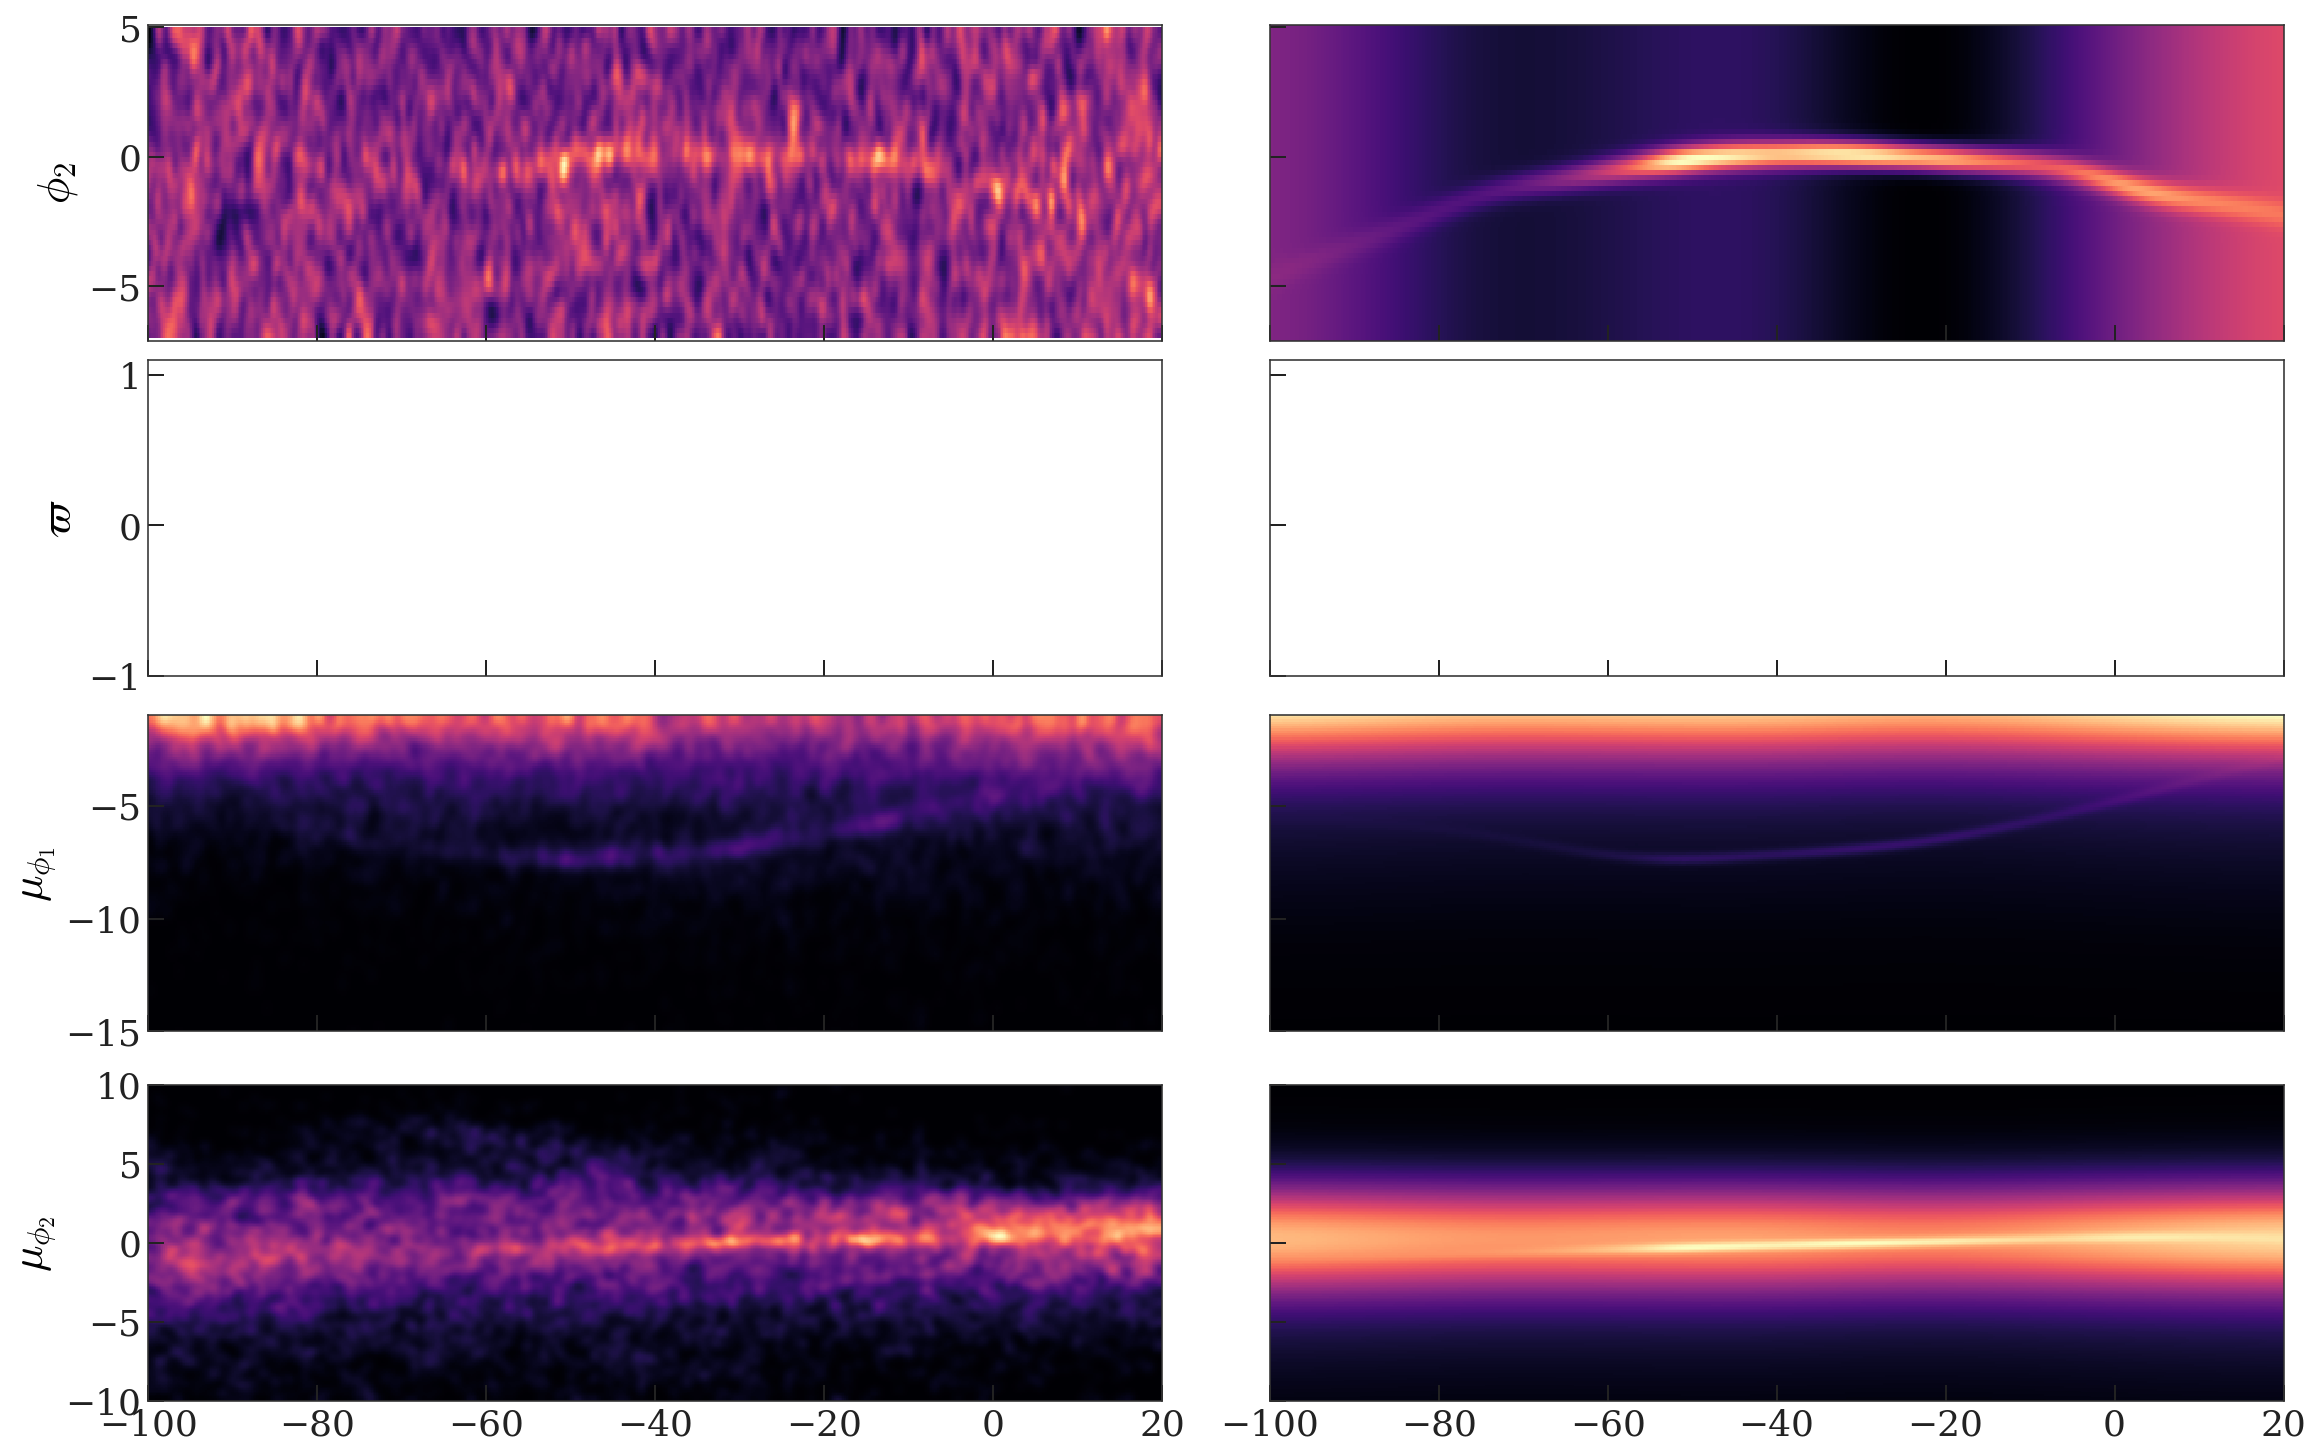

In [92]:
plot_grids = {
    'phi1': np.arange(-100, 20+1e-3, 0.2),
    'phi2': np.arange(phi2_cut[0], phi2_cut[1]+1e-3, 0.2),
    'pm1': np.arange(pm1_cut[0], pm1_cut[1]+1e-3, 0.1),
    'pm2': np.arange(-10, 10+1e-3, 0.1),
}

fig, axes = plt.subplots(4, 2, figsize=(16, 10), 
                         sharex=True, sharey='row', constrained_layout=True)

# -----------------------------------------------------
# phi2

# data
H_data, xe, ye = np.histogram2d(
    c_gd1.phi1.degree[run_mask],
    c_gd1.phi2.degree[run_mask],
    bins=(plot_grids['phi1'], plot_grids['phi2'])
)
H_data = scn.gaussian_filter(H_data, 2)
axes[0, 0].pcolormesh(xe, ye, H_data.T)

# model
grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['phi2'])
bkg_ln_dens = (
    BackgroundModel.phi2({'phi1': grid1, 'phi2': grid2}, init_pars['background'])
    + BackgroundModel.ln_n0(grid1, init_pars['background'])
)
str_ln_dens = (
    StreamModel.phi2({'phi1': grid1, 'phi2': grid2}, init_pars['stream'])
    + StreamModel.ln_n0(grid1, init_pars['stream'])
)
axes[0, 1].pcolormesh(grid1, grid2, np.exp(bkg_ln_dens) + np.exp(str_ln_dens), shading='auto')


# -----------------------------------------------------
# pm1

# data
H_data, xe, ye = np.histogram2d(
    c_gd1.phi1.degree[run_mask],
    pm1[run_mask],
    bins=(plot_grids['phi1'], plot_grids['pm1'])
)
H_data = scn.gaussian_filter(H_data, 3)
axes[2, 0].pcolormesh(xe, ye, H_data.T)

# model
grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['pm1'])
bkg_ln_dens = (
    BackgroundModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.full_like(grid1, np.median(pm1_err))}, 
                        init_pars['background'])
    + BackgroundModel.ln_n0(grid1, init_pars['background'])
)
str_ln_dens = (
    StreamModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.full_like(grid1, np.median(pm1_err))}, 
                    init_pars['stream'])
    + StreamModel.ln_n0(grid1, init_pars['stream'])
)
axes[2, 1].pcolormesh(grid1, grid2, np.exp(bkg_ln_dens) + np.exp(str_ln_dens), shading='auto')


# -----------------------------------------------------
# pm2

# data
H_data, xe, ye = np.histogram2d(
    c_gd1.phi1.degree[run_mask],
    pm2[run_mask],
    bins=(plot_grids['phi1'], plot_grids['pm2'])
)
H_data = scn.gaussian_filter(H_data, 3)
axes[3, 0].pcolormesh(xe, ye, H_data.T)

# model
grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['pm2'])
bkg_ln_dens = (
    BackgroundModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.full_like(grid1, np.median(pm2_err))}, 
                        init_pars['background'])
    + BackgroundModel.ln_n0(grid1, init_pars['background'])
)
str_ln_dens = (
    StreamModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.full_like(grid1, np.median(pm2_err))}, 
                    init_pars['stream'])
    + StreamModel.ln_n0(grid1, init_pars['stream'])
)
axes[3, 1].pcolormesh(grid1, grid2, np.exp(bkg_ln_dens) + np.exp(str_ln_dens), shading='auto')

                  
axes[1, 0].set_ylim(-1, 1.1)
axes[2, 0].set_ylim(-15, pm1_cut[1])
axes[3, 0].set_ylim(-10, 10)

axes[0, 0].set_xlim(-100, 20)
axes[0, 0].set_ylabel(r'$\phi_2$')
axes[1, 0].set_ylabel(r'$\varpi$')
axes[2, 0].set_ylabel(r'$\mu_{\phi_1}$')
axes[3, 0].set_ylabel(r'$\mu_{\phi_2}$')

In [93]:
# run_res = sco.minimize(
#     jax.value_and_grad(JointModel.objective),
#     flat_init_p,
#     args=(run_mask.sum(), run_data),
#     jac=True,
#     method="bfgs",
#     options=dict(maxiter=100_000, maxls=1000),
# )
# print(run_res)

# run_res_pars = JointModel.unpack_component_pars(JointModel.unpack_pars(run_res.x))
# run_res_pars

In [119]:
param_bounds = {
    'ln_n0_background': (-2, 8),
    'w_pm1_background': (0, 1),
    'mean1_pm1_background': (-5, 20),
    'ln_std1_pm1_background': (-5, 5),
    'mean2_pm1_background': (-5, 20),
    'ln_std2_pm1_background': (-5, 5),
    'w_pm2_background': (0, 1),
    'mean1_pm2_background': (-10, 10),
    'ln_std1_pm2_background': (-5, 5),
    'mean2_pm2_background': (-10, 10),
    'ln_std2_pm2_background': (-5, 5),
    
    'ln_n0_stream': (-8, 8),
    'mean_phi2_stream': (-8, 2),
    'ln_std_phi2_stream': (-5, 0),
    'mean_pm1_stream': (-15, 0),
    'ln_std_pm1_stream': (-5, -1),
    'mean_pm2_stream': (-5, 5),
    'ln_std_pm2_stream': (-5, -1)
}
_tmp_l = JointModel.pack_pars({k: np.full(JointModel.param_names[k], v[0], dtype='f8') 
                               for k, v in param_bounds.items()})
_tmp_r = JointModel.pack_pars({k: np.full(JointModel.param_names[k], v[1], dtype='f8')
                               for k, v in param_bounds.items()})
bounds = np.stack((_tmp_l, _tmp_r)).T
assert bounds.shape[0] == flat_init_p.shape[0]

Check that all initial paramter values are in bounds

In [120]:
for k in JointModel.param_names:
    check = (
        (flat_init_pars[k] > param_bounds[k][0]) &
        (flat_init_pars[k] < param_bounds[k][1])
    )
    if not np.all(check):
        print(flat_init_pars[k])
        print(k)

In [121]:
obj_grad = jax.jit(jax.grad(JointModel.objective))
run_res = sco.minimize(
    JointModel.objective, 
    x0=flat_init_p,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=bounds,
    args=(run_mask.sum(), run_data),
    options=dict(maxiter=100_000, maxls=1000)
)

In [122]:
run_res_pars = JointModel.unpack_component_pars(JointModel.unpack_pars(run_res.x))

In [123]:
run_res_pars['background']

{'ln_n0': DeviceArray([4.83797603, 5.23498586, 5.14862476, 5.19682595, 5.23309893,
              5.1454035 , 5.22085335, 5.31193379, 5.41646738],            dtype=float64),
 'ln_std1_pm1': DeviceArray([4.11909467, 4.11220569, 4.25796098, 4.30269762, 4.94908993,
              5.        , 4.92612186], dtype=float64),
 'ln_std1_pm2': DeviceArray([-3.01921086, -2.84141693, -2.76057165, -2.35792265,
              -1.71689051, -1.97108749, -1.89493681], dtype=float64),
 'ln_std2_pm1': DeviceArray([1.88515258, 1.63298194, 1.59568737, 1.81019522, 1.74347249,
              1.74683764, 1.84990429], dtype=float64),
 'ln_std2_pm2': DeviceArray([1.85622295, 1.33139497, 1.52577426, 1.43367193, 1.36266458,
              1.17669653, 1.37646081], dtype=float64),
 'mean1_pm1': DeviceArray([ 6.75631105,  6.54789249,  3.23192792, -0.78397553,
               2.83008895,  4.60418989,  5.52139456], dtype=float64),
 'mean1_pm2': DeviceArray([-0.52023481, -0.25429436,  0.38836462,  0.54600302,
               0

In [124]:
run_res_pars['stream']

{'ln_n0': DeviceArray([-3.02895071, -3.22610433,  3.43688775,  5.28908143,
               5.22617455,  5.16647928,  5.23431256,  5.21106104,
               5.13994989,  5.17147348,  5.11409356,  5.16623111,
               5.18694298,  5.16890604,  5.21655176,  5.25712   ,
               5.29917   ,  5.20480733,  5.1236165 ,  5.24389714,
               5.17154139,  5.13923644,  5.12115411,  5.18738684,
               5.20810909,  5.1696762 ,  5.2240235 ,  5.27040331,
               5.29860536,  5.26739398,  5.30216236,  5.39066632,
               3.87743136, -2.59972906, -1.73297991], dtype=float64),
 'ln_std_phi2': DeviceArray([-5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0., -5.], dtype=float64),
 'ln_std_pm1': DeviceArray([-1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float64),
 'ln_std_pm2': DeviceArray([-1., -1., -1., -1., -1., -1., -1.], dtype=float64),
 'mean_phi2': DeviceArray([-1.58055143, -1.87288229, -0.75607681, -1.1391265 ,

Text(0, 0.5, '$\\mu_{\\phi_2}$')

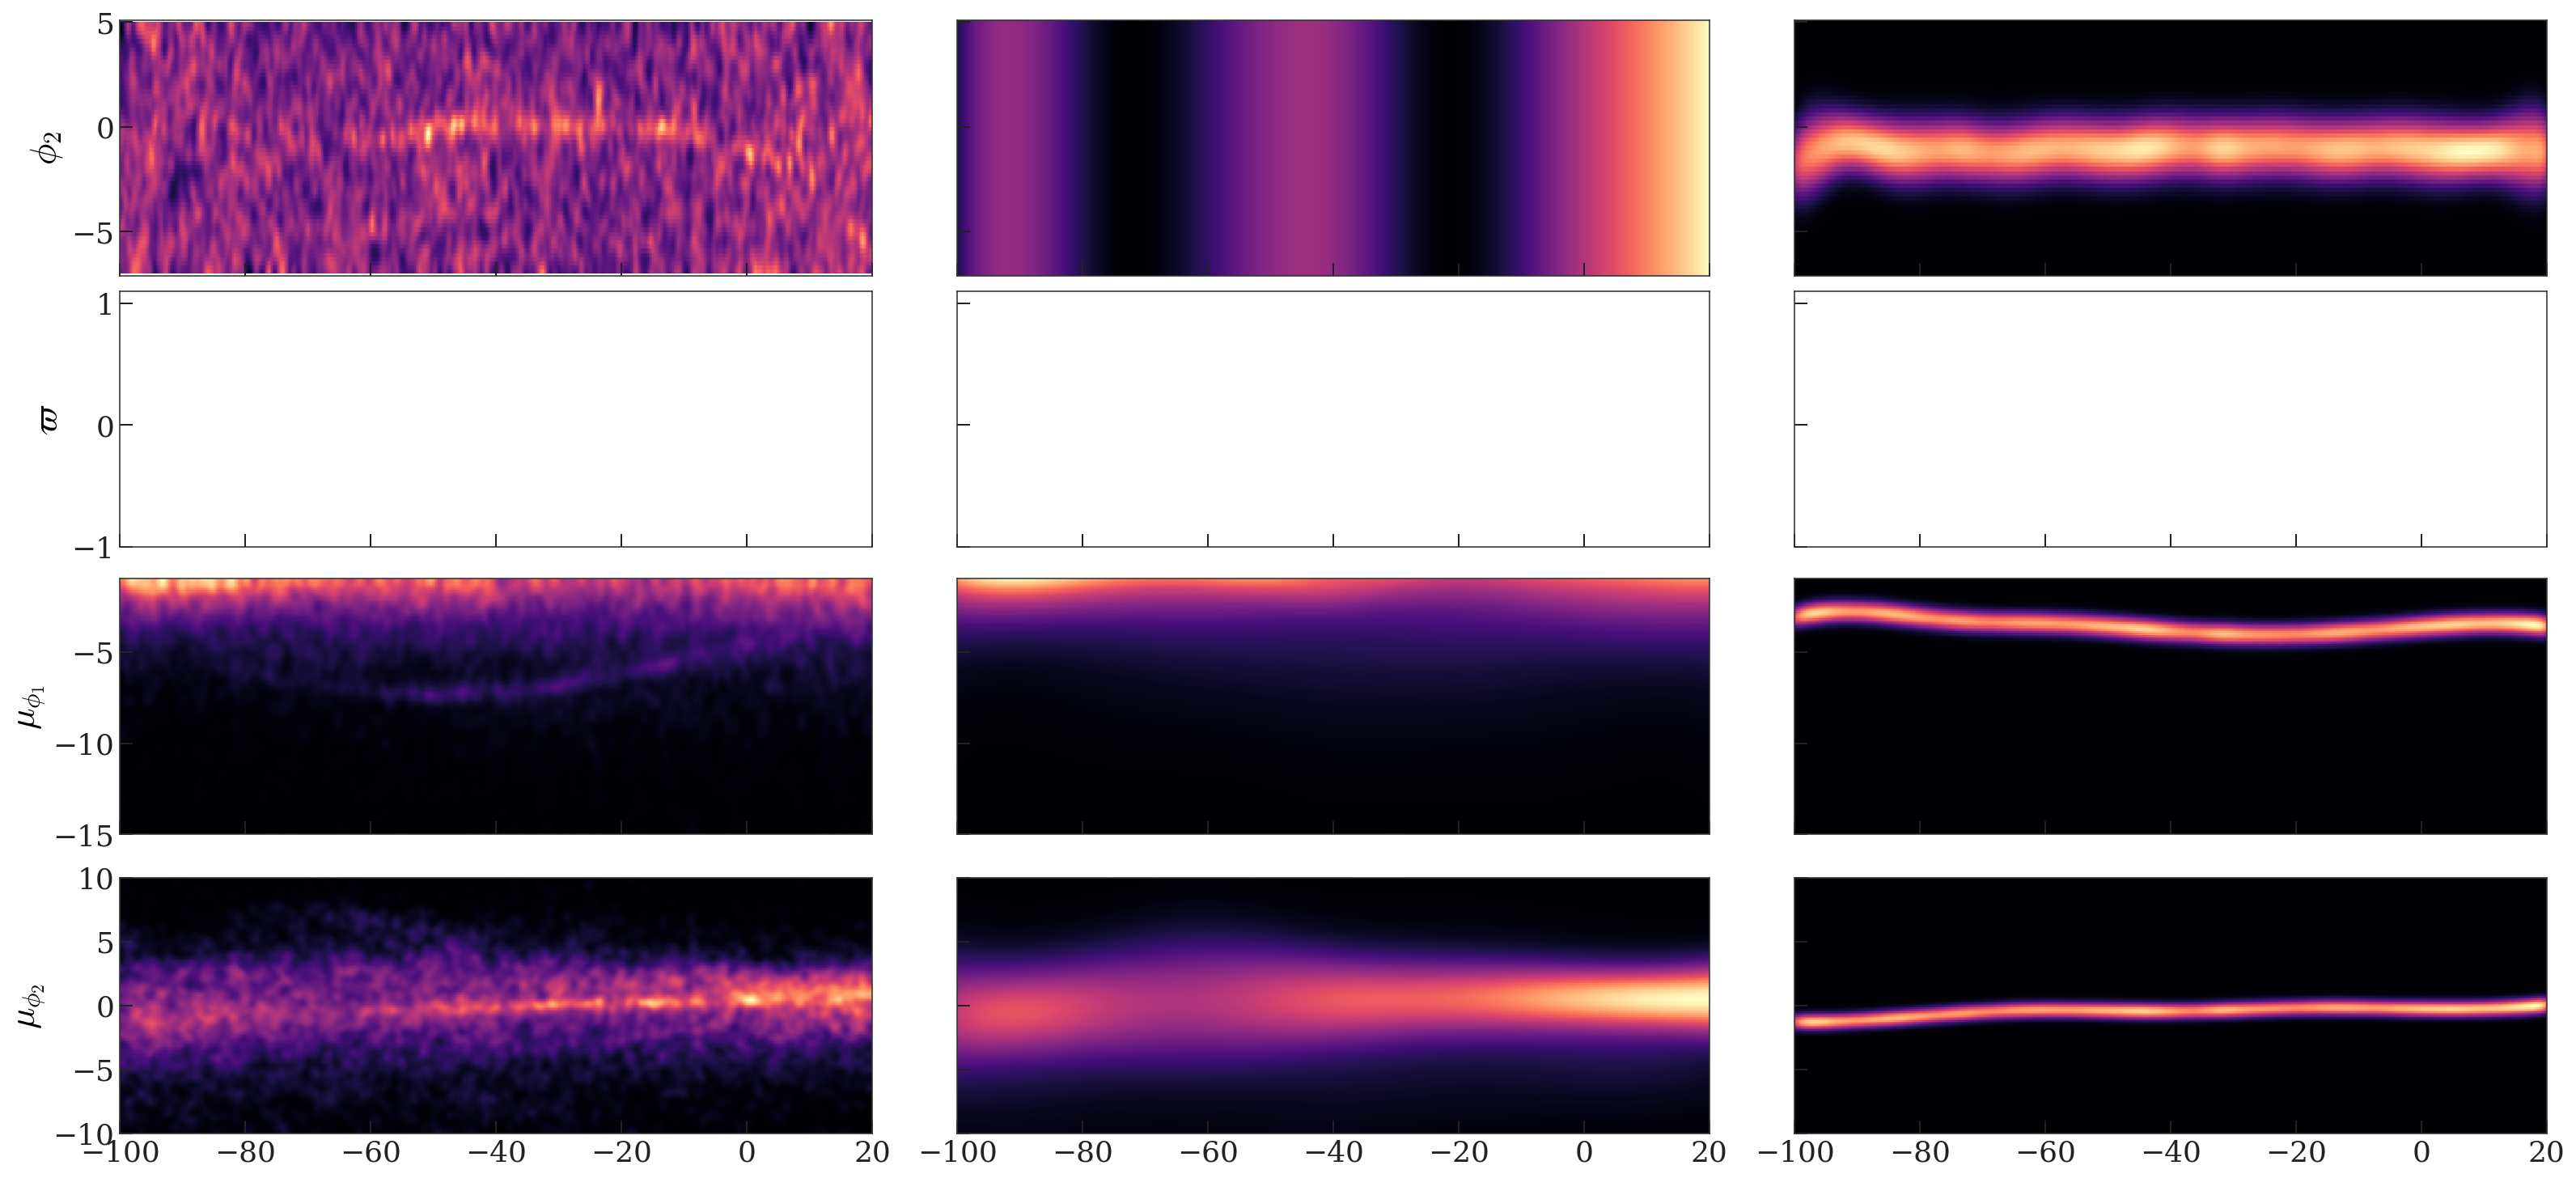

In [125]:
fig, axes = plt.subplots(4, 3, figsize=(22, 10), 
                         sharex=True, sharey='row', constrained_layout=True)

# -----------------------------------------------------
# phi2

# data
H_data, xe, ye = np.histogram2d(
    c_gd1.phi1.degree[run_mask],
    c_gd1.phi2.degree[run_mask],
    bins=(plot_grids['phi1'], plot_grids['phi2'])
)
H_data = scn.gaussian_filter(H_data, 2)
axes[0, 0].pcolormesh(xe, ye, H_data.T)

# model
grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['phi2'])
bkg_ln_dens = (
    BackgroundModel.phi2({'phi1': grid1, 'phi2': grid2}, run_res_pars['background'])
    + BackgroundModel.ln_n0(grid1, run_res_pars['background'])
)
str_ln_dens = (
    StreamModel.phi2({'phi1': grid1, 'phi2': grid2}, run_res_pars['stream'])
    + StreamModel.ln_n0(grid1, run_res_pars['stream'])
)
axes[0, 1].pcolormesh(grid1, grid2, np.exp(bkg_ln_dens), shading='auto')
axes[0, 2].pcolormesh(grid1, grid2, np.exp(str_ln_dens), shading='auto')


# -----------------------------------------------------
# pm1

# data
H_data, xe, ye = np.histogram2d(
    c_gd1.phi1.degree[run_mask],
    pm1[run_mask],
    bins=(plot_grids['phi1'], plot_grids['pm1'])
)
H_data = scn.gaussian_filter(H_data, 3)
axes[2, 0].pcolormesh(xe, ye, H_data.T)

# model
grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['pm1'])
bkg_ln_dens = (
    BackgroundModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.full_like(grid1, np.median(pm1_err))}, 
                        run_res_pars['background'])
    + BackgroundModel.ln_n0(grid1, run_res_pars['background'])
)
str_ln_dens = (
    StreamModel.pm1({'phi1': grid1, 'pm1': grid2, 'pm1_error': np.full_like(grid1, np.median(pm1_err))}, 
                    run_res_pars['stream'])
    + StreamModel.ln_n0(grid1, run_res_pars['stream'])
)
axes[2, 1].pcolormesh(grid1, grid2, np.exp(bkg_ln_dens), shading='auto')
axes[2, 2].pcolormesh(grid1, grid2, np.exp(str_ln_dens), shading='auto')


# -----------------------------------------------------
# pm2

# data
H_data, xe, ye = np.histogram2d(
    c_gd1.phi1.degree[run_mask],
    pm2[run_mask],
    bins=(plot_grids['phi1'], plot_grids['pm2'])
)
H_data = scn.gaussian_filter(H_data, 3)
axes[3, 0].pcolormesh(xe, ye, H_data.T)

# model
grid1, grid2 = np.meshgrid(plot_grids['phi1'], plot_grids['pm2'])
bkg_ln_dens = (
    BackgroundModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.full_like(grid1, np.median(pm2_err))}, 
                        run_res_pars['background'])
    + BackgroundModel.ln_n0(grid1, run_res_pars['background'])
)
str_ln_dens = (
    StreamModel.pm2({'phi1': grid1, 'pm2': grid2, 'pm2_error': np.full_like(grid1, np.median(pm2_err))}, 
                    run_res_pars['stream'])
    + StreamModel.ln_n0(grid1, run_res_pars['stream'])
)
axes[3, 1].pcolormesh(grid1, grid2, np.exp(bkg_ln_dens), shading='auto')
axes[3, 2].pcolormesh(grid1, grid2, np.exp(str_ln_dens), shading='auto')

                  
axes[1, 0].set_ylim(-1, 1.1)
axes[2, 0].set_ylim(-15, pm1_cut[1])
axes[3, 0].set_ylim(-10, 10)

axes[0, 0].set_xlim(-100, 20)
axes[0, 0].set_ylabel(r'$\phi_2$')
axes[1, 0].set_ylabel(r'$\varpi$')
axes[2, 0].set_ylabel(r'$\mu_{\phi_1}$')
axes[3, 0].set_ylabel(r'$\mu_{\phi_2}$')